##**Dependencies**

---






In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

##**Data Import from Gdrive**


---




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%%time
train = pd.read_csv('/content/drive/My Drive/PUBG Pred Data/train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('/content/drive/My Drive/PUBG Pred Data/test_V2.csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(4446966, 29) (1934174, 28)
CPU times: user 24 s, sys: 3.49 s, total: 27.4 s
Wall time: 34.5 s


# **Dataset Description**

get the data from :

[Dataset and problem statement](https://www.kaggle.com/c/pubg-finish-placement-prediction/overview)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

In [6]:
train.head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000000,1,1,0,44,0,1,1,18.440001,1395,squad-fpp,28,28,1418,0,0.0000,0,0.00,0,0,34.700001,1,0,0.0370
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000000,0,0,0,96,1262,0,0,0.000000,1316,squad-fpp,28,28,-1,0,0.0000,0,0.00,0,0,13.500000,1,1497,0.0000
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538000,0,0,0,48,1000,0,0,0.000000,1967,solo-fpp,96,92,-1,0,2004.0000,0,0.00,0,0,1089.000000,6,1500,0.7368
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.599998,0,0,0,64,0,0,0,0.000000,1375,squad,28,27,1493,0,0.0000,0,0.00,0,0,799.900024,4,0,0.3704
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.270000,0,0,0,74,0,0,0,0.000000,1930,squad,29,27,1349,0,0.0000,0,0.00,0,0,65.669998,1,0,0.2143


In [7]:
train.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.000000,0,0,0,74,1029,0,0,0.00,1873,squad-fpp,29,28,-1,0,1292.0,0,0.000,0,0,1019.000000,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.150002,0,0,0,69,0,0,0,0.00,1435,solo,93,93,1501,0,0.0,0,0.000,0,0,81.699997,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.060001,0,0,0,66,0,0,0,0.00,1321,squad-fpp,28,28,1500,0,0.0,0,2.184,0,0,788.700012,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.399994,1,1,2,11,0,2,1,98.50,1373,squad-fpp,26,25,1418,2,0.0,0,0.000,0,0,2748.000000,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.000000,0,0,1,18,0,2,1,78.25,1766,solo-fpp,98,94,1590,0,1369.0,0,0.000,0,0,1244.000000,5,0,0.5464


#EDA

In [8]:
for i in ['Id','groupId','matchId']:
    print(f'unique [{i}] count:', train[i].nunique())

unique [Id] count: 4446966
unique [groupId] count: 2026745
unique [matchId] count: 47965


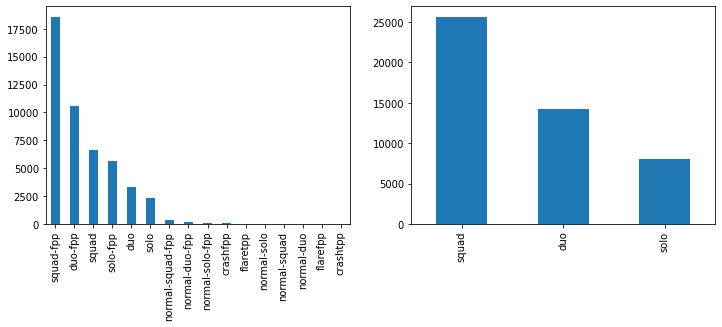

In [9]:
#different match types now i.e solo,duo and squads
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

In [10]:
#player analysis
def mergeList(list1,list2):
    return list(itertools.product(list1,list2))
match = train.groupby(['matchType','matchId']).size().to_frame('players in match')
group = train.groupby(['matchType','matchId','groupId']).size().to_frame('players in group')
pd.concat([match.groupby('matchType').describe()[mergeList(['players in match'],['min','mean','max'])], 
           group.groupby('matchType').describe()[mergeList(['players in group'],['min','mean','max'])]], axis=1)

players in match                   players in group                
                       min       mean    max              min      mean   max
matchType                                                                    
duo                    7.0  92.985658  100.0              1.0  2.050456  72.0
solo                   1.0  89.031872  100.0              1.0  1.039249  64.0
squad                  5.0  93.723193  100.0              1.0  3.492575  74.0

In [11]:
print(group['players in group'].nlargest(5))

matchType  matchId         groupId       
squad      b30f3d87189aa6  14d6b54cdec6bc    74
duo        3e029737889ce9  b8275198faa03b    72
solo       41a634f62f86b7  128b07271aa012    64
duo        7e93ce71ac6f61  7385e5fe214021    49
squad      3c2531adf5b942  e52a2e6ca30474    36
Name: players in group, dtype: int64


In [12]:
''' ex) matchId=='3e029737889ce9', groupId=='b8275198faa03b'
'''
subset = train[train['matchId']=='3e029737889ce9']
sub_grp = subset[subset['groupId']=='b8275198faa03b']

print('matchId ==\'3e029737889ce9\' & groupId ==\'b8275198faa03b\'')
print('-'*50)
print('players:',len(subset))
print('groups:',subset['groupId'].nunique())
print('numGroups:',subset['numGroups'].unique())
print('maxPlace:',subset['maxPlace'].unique())
print('-'*50)
print('max-group players:',len(sub_grp))
print('max-group winPlacePerc:',sub_grp['winPlacePerc'].unique())
print('-'*50)
print('winPlacePerc:',subset['winPlacePerc'].sort_values().unique())

matchId =='3e029737889ce9' & groupId =='b8275198faa03b'
--------------------------------------------------
players: 99
groups: 14
numGroups: [14]
maxPlace: [50]
--------------------------------------------------
max-group players: 72
max-group winPlacePerc: [0.2449]
--------------------------------------------------
winPlacePerc: [0.     0.0204 0.0408 0.0612 0.0816 0.102  0.1224 0.1633 0.1837 0.2041
 0.2245 0.2449 0.5102 1.    ]


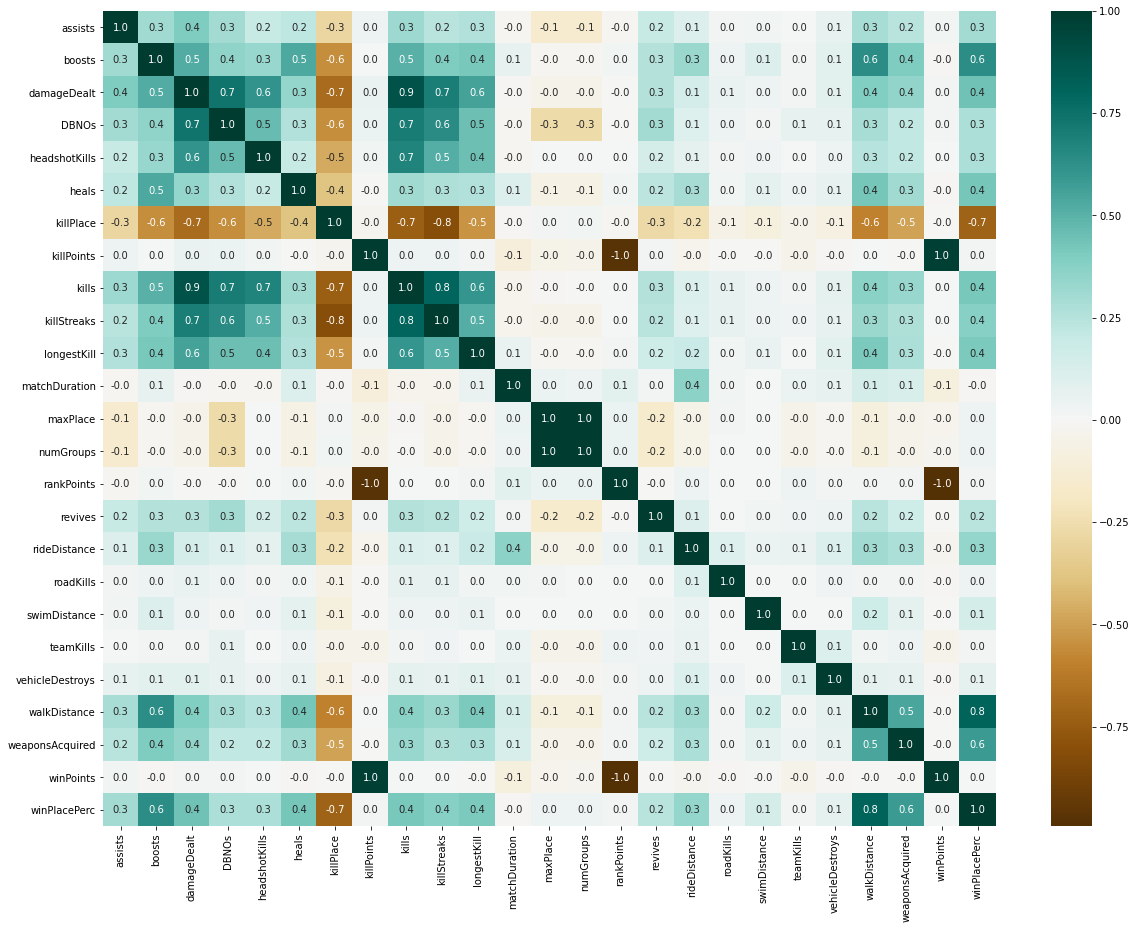

In [13]:
#correlation with win%

corr = train.corr()
f,ax = plt.subplots(figsize=(20, 15))
sns.heatmap(train.corr(), annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

# **Feature Engineering**

In [14]:
print("On an average a person kills {:.4f} players, 99% of people have {} kills or less, while the maximum kills ever recorded is {}.".format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

On an average a person kills 0.9248 players, 99% of people have 7.0 kills or less, while the maximum kills ever recorded is 72.


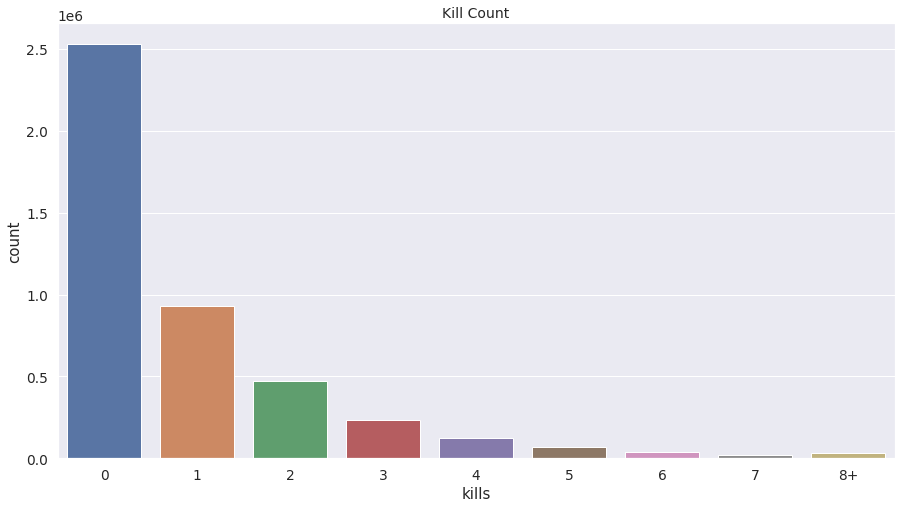

In [15]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,8))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=14)
plt.show()

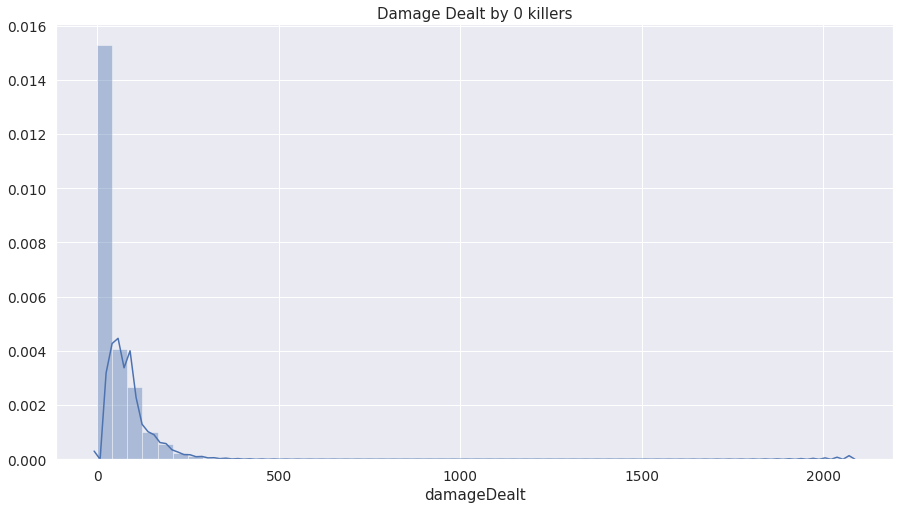

In [16]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,8))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

In [17]:
print("A total of {} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))
data1 = train[train['damageDealt'] == 0].copy()
print("A total of {} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

A total of 16666 players (0.3748%) have won without a single kill!
A total of 4770 players (0.1073%) have won without dealing damage!


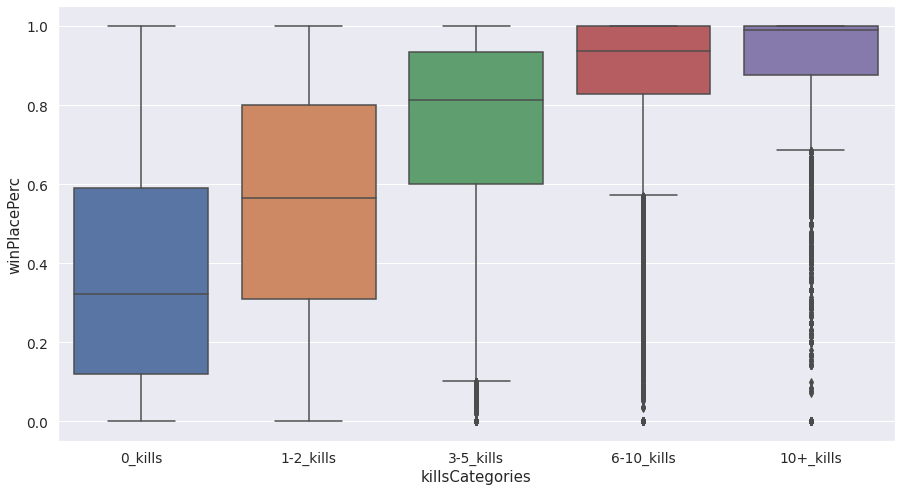

In [18]:
#effect of kills on win %
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

## Analysing Running and riding vehicles etc

In [19]:
print("{} players ({:.4f}%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(train)))

98054 players (2.0329%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).


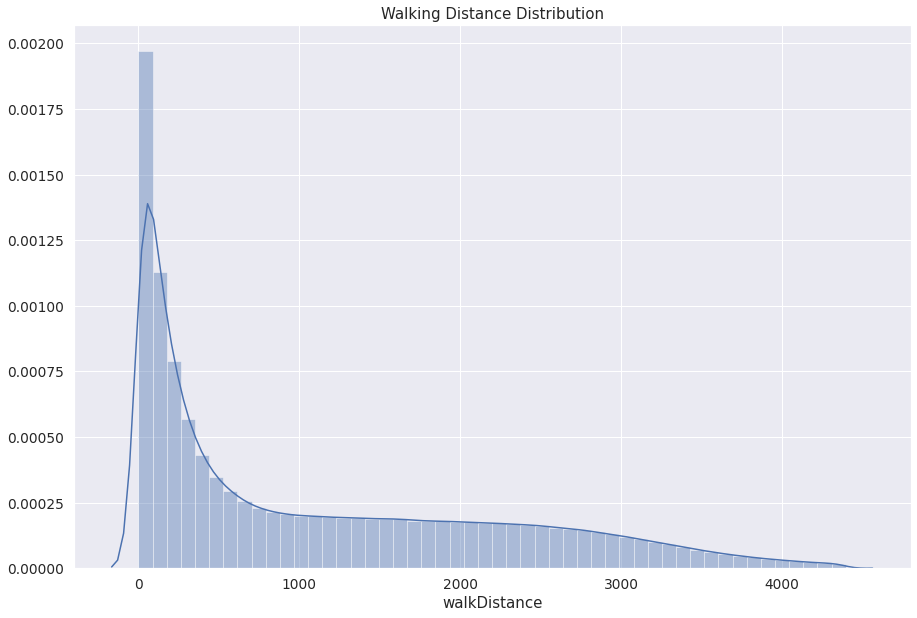

In [20]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

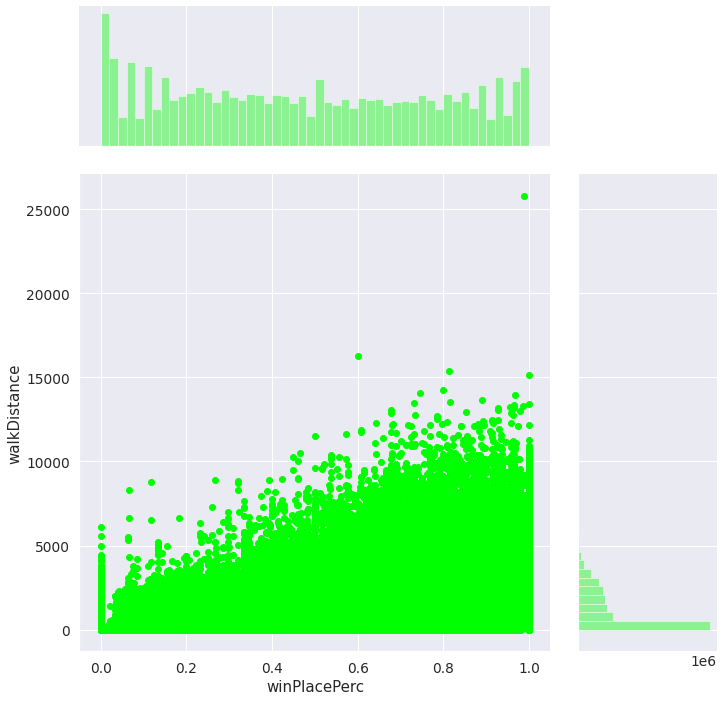

In [21]:
#affect of running on win %
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=10, ratio=3, color="lime")
plt.show()

In [22]:
#riding
print("An average person drives for {:.1f}m, 99% of people have drived {}m or less, while THE RIDER rode for {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

An average person drives for 606.1m, 99% of people have drived 6966.0m or less, while THE RIDER rode for 40710.0m.


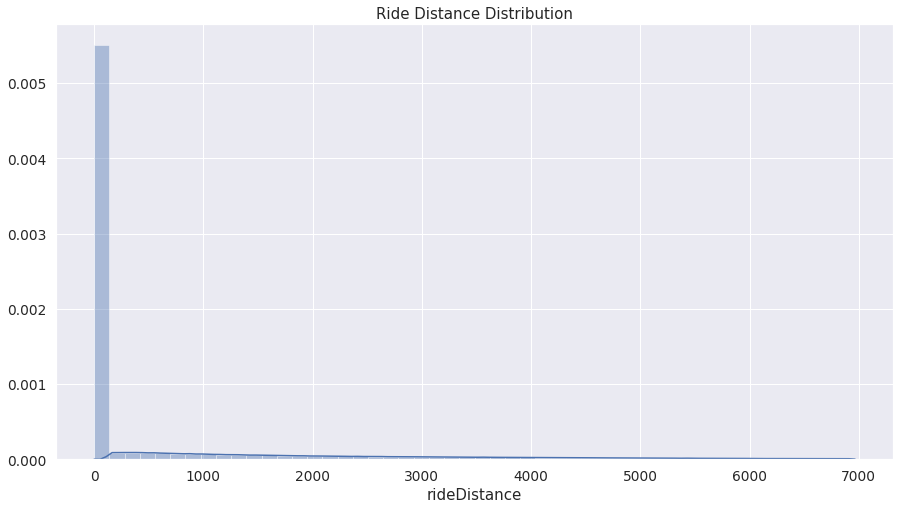

3309429 players (23.1022%) drived for 0 meters. This means that they like trekking more than riding.


In [23]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.99)]
plt.figure(figsize=(15,8))
plt.title("Ride Distance Distribution",fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

print("{} players ({:.4f}%) drived for 0 meters. This means that they like trekking more than riding.".format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(train)))

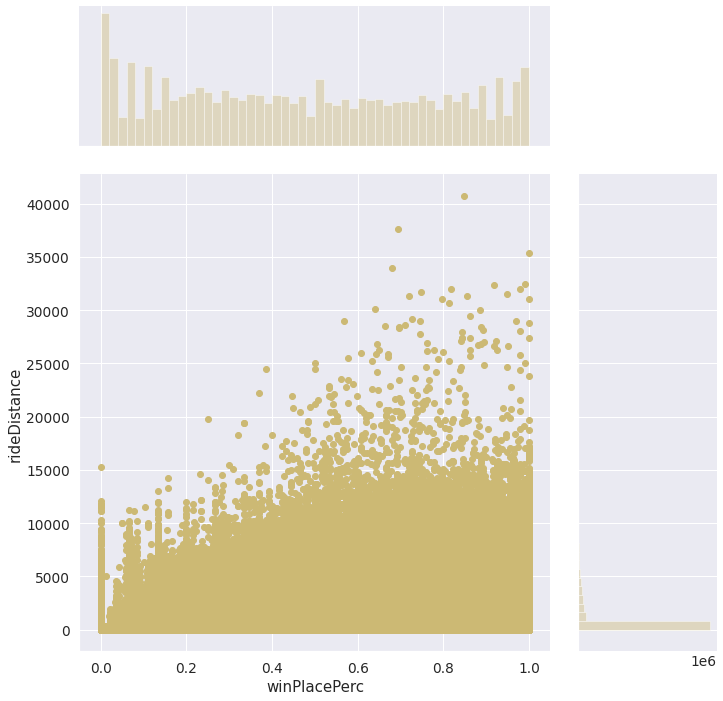

In [24]:
#affect of riding on win%
sns.jointplot(x="winPlacePerc", y="rideDistance", data=train, height=10, ratio=3, color="y")
plt.show()

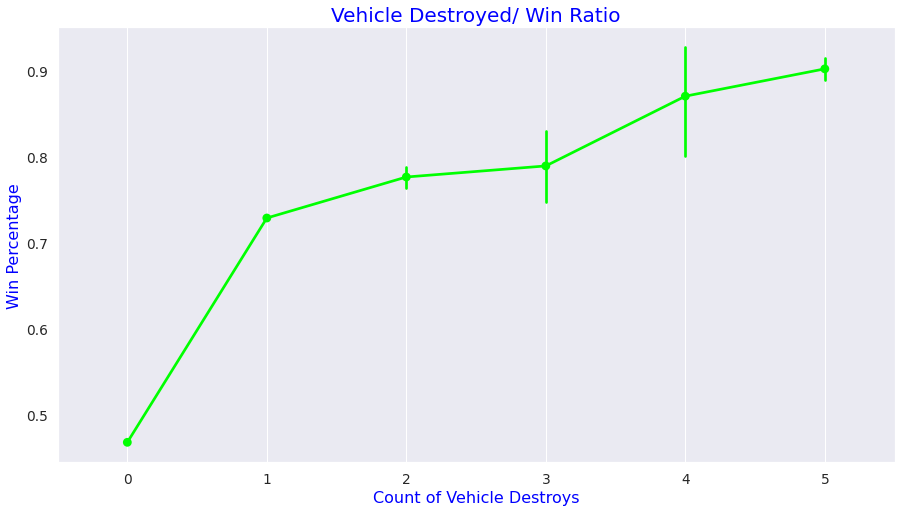

In [25]:
#vehicles destoyed etc
f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='lime',alpha=0.5)
plt.xlabel('Count of Vehicle Destroys',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Vehicle Destroyed/ Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

# **Healing and boosts**

In [26]:
print("In the game on an average a person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("In the game on an average a person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

In the game on an average a person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
In the game on an average a person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


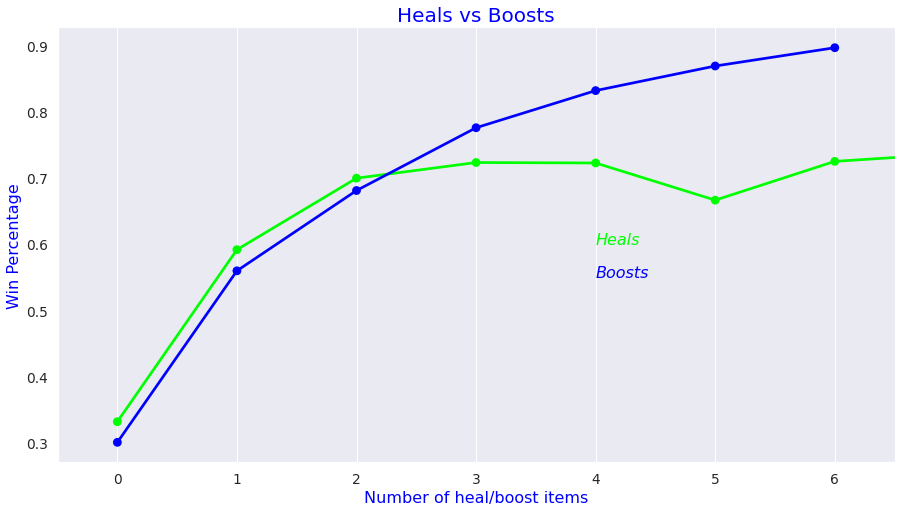

In [27]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 16,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 16,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

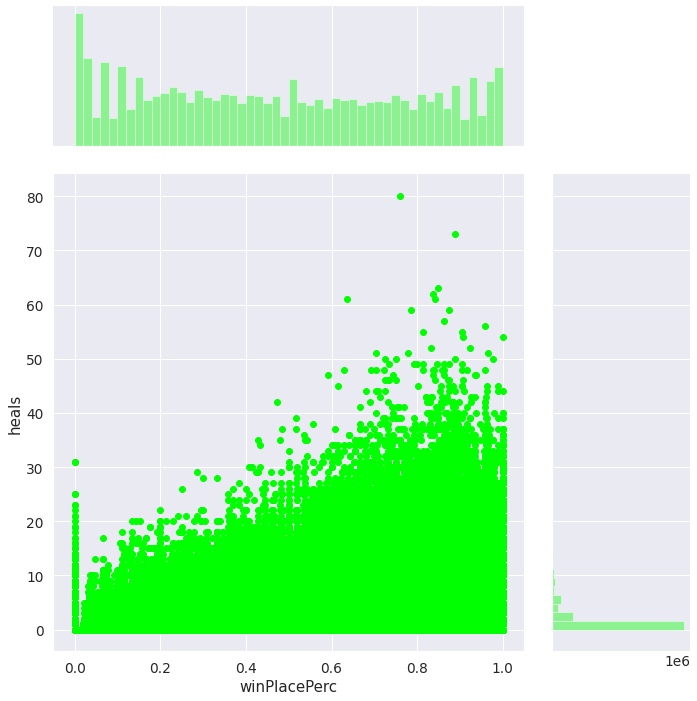

In [31]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, height=10, ratio=3, color="lime")
plt.show()

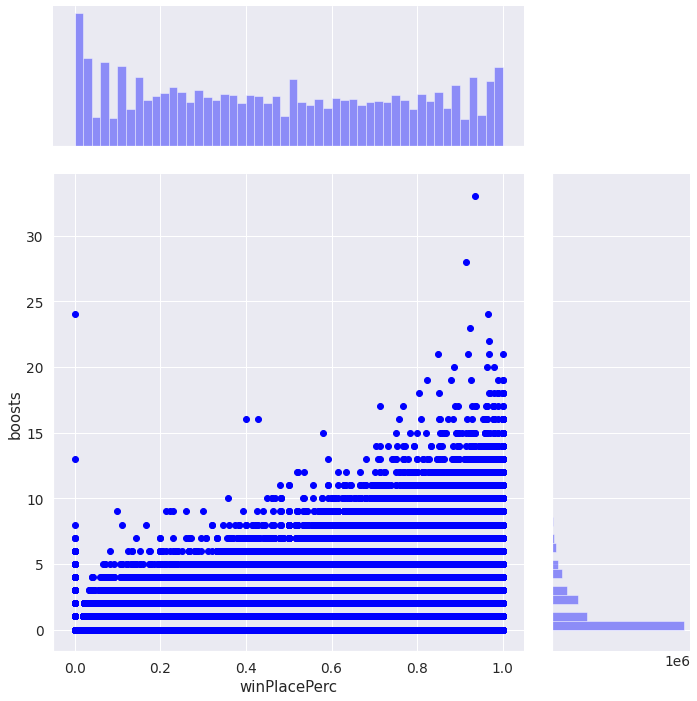

In [29]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="blue")
plt.show()

##Effect of Killing in different Game types

In [32]:
solos = train[train['numGroups']>50] #Solo game played by more than 50 different groups
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)] #Duo game can consist of a maximum of 50 groups(50x2=100) 
squads = train[train['numGroups']<=25] # Squad game can consist a maximum of 25 groups(25x4=100)
print("{} ({:.2f}%) of games are solo, {} ({:.2f}%) are duo and {} ({:.2f}%) are squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train),))

709111 (15.95%) of games are solo, 3295326 (74.10%) are duo and 442529 (9.95%) are squad games.


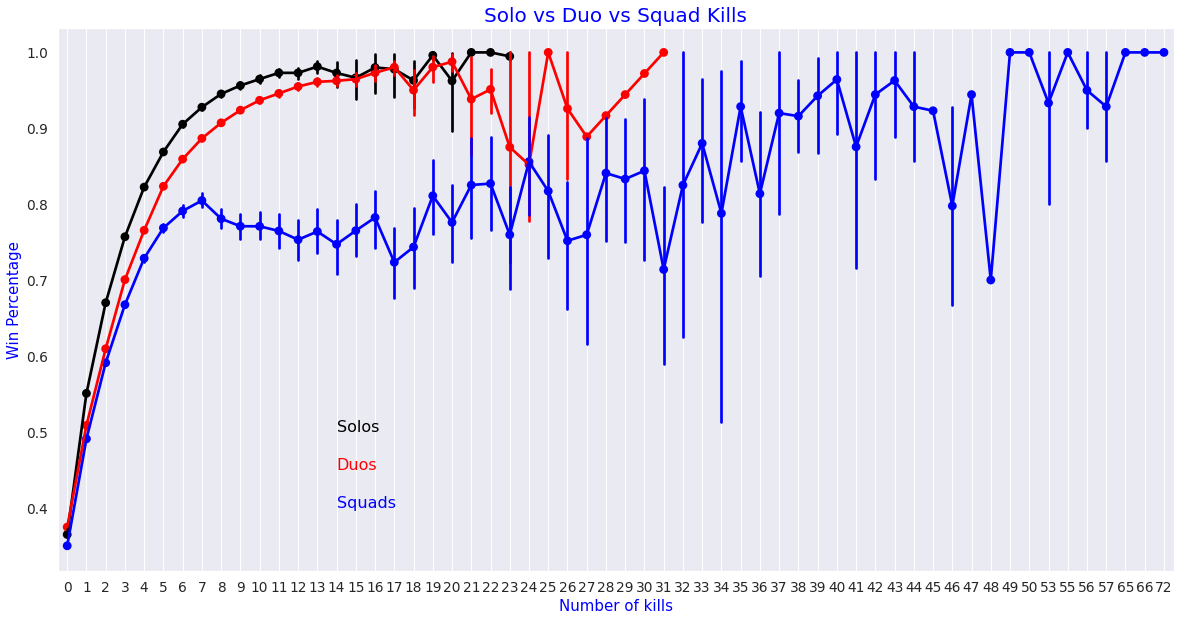

In [33]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='red',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='blue',alpha=0.6)
plt.text(14,0.5,'Solos',color='black',fontsize = 16)
plt.text(14,0.45,'Duos',color='red',fontsize = 16)
plt.text(14,0.4,'Squads',color='blue',fontsize = 16)
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

#**Outliers:Anomalies ,hackings etc**



In [0]:
#Aimbots,aim hackings etc
train['_totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
train['_headshot_rate'] = train['headshotKills'] / train['kills']
train['_headshot_rate'] = train['_headshot_rate'].fillna(0)
def show_countplot(column):
    plt.figure(figsize=(15,8))
    sns.countplot(data=train, x=column).set_title(column)
    plt.show()
    
def show_distplot(column):
    plt.figure(figsize=(15, 8))
    sns.distplot(train[column], bins=50)
    plt.show()

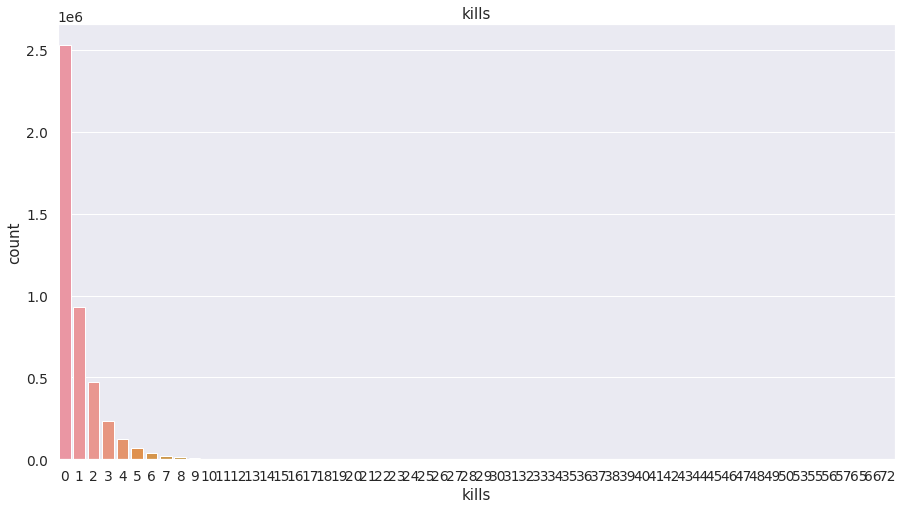

In [35]:
#inhumane kills
show_countplot('kills')

In [36]:
# Is it even possible to kill more than 40 people by acquiring more than 55 weapons and maintaining a total distance of less than 100m?
train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['_totalDistance'] < 100.0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,0,48,6,81.949997,1798,solo,11,11,1500,0,0.0,0,0.0,0,0,23.709999,61,0,0.7000,23.709999,0.250000
672993,da31f191ace8ed,ce9a3c4950a8f2,17dea22cefe62a,10,0,5793.0,0,5,2,1,0,57,5,104.199997,1798,duo,15,12,1500,0,0.0,0,0.0,0,0,24.270000,56,0,1.0000,24.270000,0.087719
770454,2ade4369bccd12,9f9e64a3db8384,e024bf51bf1799,12,0,5557.0,0,7,4,1,0,55,6,74.790001,1798,solo,19,18,1500,0,0.0,0,0.0,0,0,85.550003,66,0,1.0000,85.550003,0.127273
1378200,f241fdbb4f94c6,fadbbc4cbb3e06,e024bf51bf1799,9,0,3707.0,0,5,1,5,0,41,4,188.100006,1798,solo,19,18,1500,0,0.0,0,0.0,0,0,46.709999,72,0,0.7778,46.709999,0.121951


In [37]:
# Is it even possible to kill more than 40 people without using any heals?
train[(train['kills'] >= 40) & (train['heals'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,1000,42,5,266.200012,844,squad,8,8,-1,0,0.0,0,0.0,1,0,718.299988,16,1500,1.0,718.299988,0.952381
2105633,770c02791306c4,48ca6706a90e10,6ee2c835176181,8,0,4272.0,40,34,0,1,0,43,9,248.800003,911,squad,6,6,1500,1,0.0,0,0.0,0,0,80.400002,21,0,1.0,80.400002,0.790698
2316123,dbc81aa64a7e3d,c50fe5c54e8bb6,5d58307bae9b50,8,0,4106.0,31,3,0,1,0,40,6,365.200012,1066,squad,10,9,1500,0,0.0,0,0.0,0,0,1282.000000,22,0,1.0,1282.000000,0.075000
2601666,436d1530e9eb00,5c974c2bb9d9f0,fe7043ee6221c8,5,0,4347.0,0,31,0,1,0,53,8,135.600006,1116,solo,37,26,1500,0,0.0,0,0.0,0,0,134.300003,36,0,1.0,134.300003,0.584906
3924729,579949f753978c,108f4c00d80882,ff9cd80c0d8fb7,1,2,3680.0,0,35,0,1,1000,40,20,621.799988,799,squad,10,10,-1,0,0.0,0,0.0,0,0,1180.000000,2,1500,1.0,1180.000000,0.875000


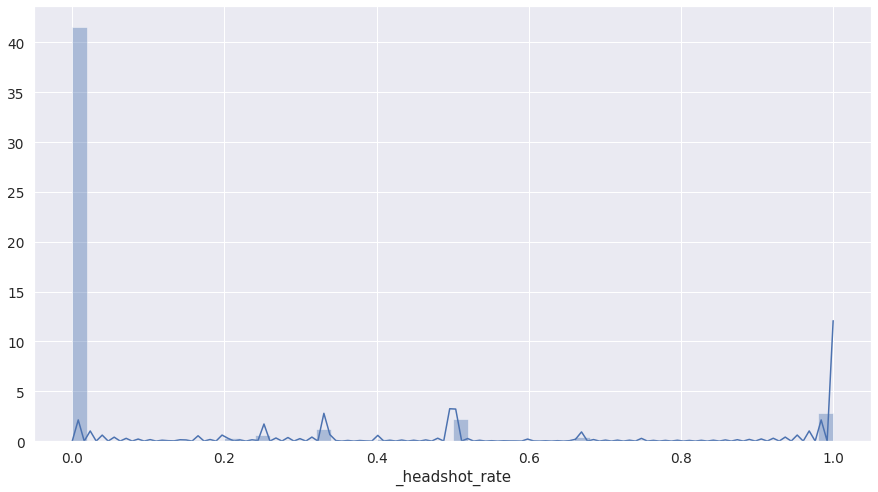

In [38]:
#100% headshot rate
show_distplot("_headshot_rate")

In [40]:
#List of players who made more than 10 kills and all the kills were done by headshots
display(train[(train['_headshot_rate'] == 1) & (train['kills'] >=10)].shape)
train[(train['_headshot_rate'] == 1) & (train['kills'] >= 10)].head(10)

(24, 31)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,0,10,4,159.199997,1423,squad,27,25,1564,1,0.000000,0,0.000000,0,0,2939.0,5,0,0.8462,2939.000000,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.599976,1727,squad,27,26,-1,3,4720.000000,0,0.000000,0,0,3422.0,8,1560,1.0000,8142.000000,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,1579,13,2,353.799988,1255,squad,27,27,-1,0,0.000000,0,0.000000,0,0,2105.0,5,1587,1.0000,2105.000000,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,1393,10,3,533.200012,1838,squad,28,24,-1,0,5187.000000,0,0.000000,2,0,2761.0,7,1519,0.9630,7948.000000,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.000000,1417,squad,27,26,-1,0,1018.000000,0,0.000000,0,0,2458.0,4,1562,1.0000,3476.000000,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,0,11,3,484.899994,1821,squad,28,27,1495,0,5246.000000,0,0.000000,0,0,2932.0,4,0,1.0000,8178.000000,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,1391,10,2,222.000000,1246,squad,27,27,-1,0,408.899994,0,0.000000,0,0,2450.0,7,1468,1.0000,2858.899902,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,0,12,2,443.000000,1730,squad,28,28,1560,0,2048.000000,0,0.000000,0,0,3915.0,5,0,1.0000,5963.000000,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,1000,11,3,289.600006,1248,duo,46,41,0,1,0.000000,0,0.000000,0,0,3108.0,7,1500,1.0000,3108.000000,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,0,13,3,95.139999,1379,duo,49,48,1813,0,0.000000,0,140.800003,0,0,2339.0,4,0,1.0000,2479.800049,1.0


In [41]:
# Create feature killsWithoutMoving
train['_killsWithoutMoving'] = ((train['kills'] > 0) & (train['_totalDistance'] == 0))
# Check players who kills without moving
display(train[train['_killsWithoutMoving'] == True].shape)
train[train['_killsWithoutMoving'] == True].head(10)

(1535, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.000000,0,0,3,18,0,6,3,23.540001,593,squad,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,0.0,0.000000,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.600006,0,0,6,33,0,3,1,6.523000,1794,squad,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.6000,0.0,0.000000,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000000,0,4,5,3,0,20,6,37.080002,898,solo,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.8947,0.0,0.200000,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.800003,0,0,0,69,1000,1,1,21.540001,799,squad,19,18,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.0000,0.0,0.000000,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.000000,0,1,0,37,0,1,1,55.430000,1794,squad,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.3000,0.0,1.000000,True
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.100006,4,1,3,7,0,6,2,81.919998,583,squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8000,0.0,0.166667,True
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.000000,0,4,1,7,0,12,5,116.300003,550,squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.6000,0.0,0.333333,True
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.900024,0,2,11,12,0,7,2,84.370003,599,squad,15,15,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,0.0,0.285714,True
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.899994,0,1,6,53,1000,2,1,26.990000,732,squad,8,8,-1,0,0.0,0,0.0,0,0,0.0,12,1500,0.2857,0.0,0.500000,True
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.559998,0,0,0,46,0,1,1,16.440001,715,squad,15,14,1500,0,0.0,0,0.0,0,0,0.0,4,0,0.8571,0.0,0.000000,True


In [0]:
# Drop kill without moving 'cheaters'
train.drop(train[train['_killsWithoutMoving'] == True].index, inplace=True)

##**LONG KILLS**




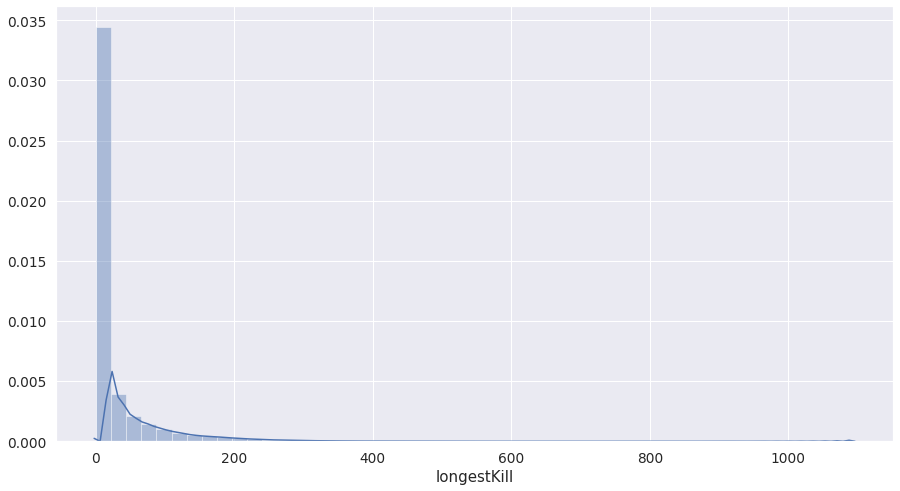

In [43]:
show_distplot('longestKill')

In [44]:
train[train['longestKill'] >= 1000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.900024,5,1,1,5,0,4,3,1000.0,1864,squad,27,27,1482,0,723.200012,0,0.000000,0,1,3052.000000,9,0,0.9231,3775.199951,0.250000,False
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.000000,8,5,7,18,1000,11,2,1004.0,1308,duo,14,13,-1,1,0.000000,0,0.000000,0,0,48.869999,38,1500,0.5385,48.869999,0.454545,False
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.000000,0,0,0,9,0,10,2,1026.0,698,squad,13,13,1500,0,1717.000000,0,0.000000,0,0,1264.000000,26,0,1.0000,2981.000000,0.000000,False
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.000000,17,5,0,3,1000,16,4,1000.0,1091,squad,6,6,-1,4,0.000000,0,0.000000,0,0,29.209999,30,1500,0.6000,29.209999,0.312500,False
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.800003,0,0,0,51,0,1,1,1075.0,471,squad,8,8,1500,0,2085.000000,0,0.000000,0,0,1074.000000,22,0,0.0000,3159.000000,0.000000,False
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.000000,11,5,0,5,0,10,3,1094.0,1021,squad,12,12,1500,0,0.000000,0,0.000000,0,0,569.500000,18,0,0.9091,569.500000,0.500000,False
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.299988,0,0,2,45,1000,3,1,1037.0,581,squad,8,7,-1,0,0.000000,0,0.000000,0,0,832.500000,9,1500,0.2857,832.500000,0.000000,False
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.000000,0,7,0,1,1000,15,2,1001.0,1235,solo,52,51,-1,0,0.000000,0,0.000000,0,0,2848.000000,4,1500,0.9412,2848.000000,0.466667,False
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.000000,0,4,11,11,0,23,2,1005.0,1798,duo,15,12,1500,0,0.000000,0,0.000000,0,0,235.300003,41,0,0.5000,235.300003,0.173913,False
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.000000,0,6,5,15,0,11,2,1037.0,1794,squad,11,11,1500,0,0.000000,0,0.000000,0,0,133.199997,43,0,0.6000,133.199997,0.545455,False


In [0]:
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

## More than 10 road kills


In [46]:
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181000,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.000000,0,1371,0.4286,1282.302002,0.000000,False
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.599976,5,1533,0.4713,4934.600098,0.000000,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290001,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.000000,4,1568,1.0000,5876.000000,0.050000,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.399994,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.000000,10,1606,0.9398,7853.000000,0.277778,False


In [0]:
train.drop(train[train['roadKills'] > 10].index, inplace=True)

#**Travel anomalies**

In [48]:
train[['walkDistance', 'rideDistance', 'swimDistance']].describe()

,walkDistance,rideDistance,swimDistance
count,4.445407e+06,4.445407e+06,4.445407e+06
mean,1.148914e+03,6.062993e+02,4.510799e+00
std,1.180579e+03,1.496634e+03,3.024290e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.554000e+02,0.000000e+00,0.000000e+00
50%,6.863000e+02,0.000000e+00,0.000000e+00
75%,1.977000e+03,2.593000e-01,0.000000e+00
max,2.578000e+04,4.071000e+04,3.823000e+03


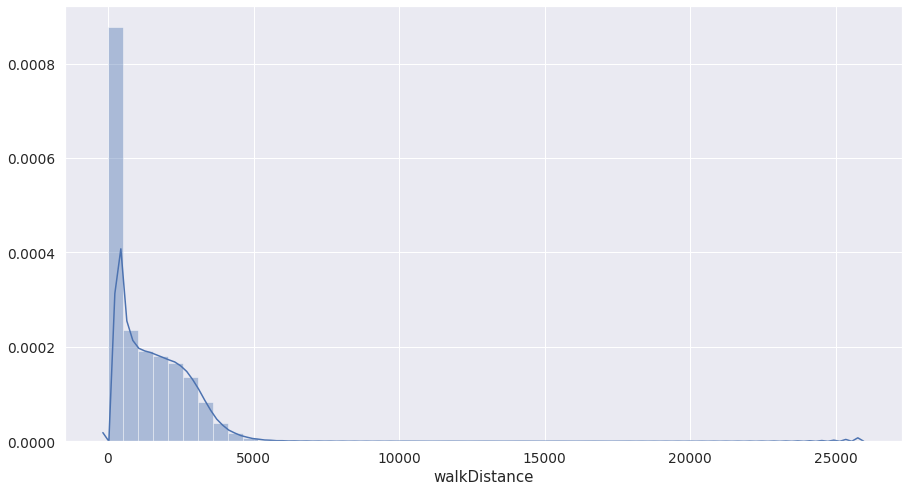

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.000000,0,0,0,44,0,0,0,0.0,1906,solo,99,93,1517,0,0.421200,0,9.882000,0,0,13530.0,7,0,0.8163,13540.302734,0.0,False
497965,3304d0c68e27f5,503757159d22dd,ce88f9c8c35bdf,0,0,0.000000,0,0,0,46,0,0,0,0.0,1889,solo,95,93,1520,0,0.007800,0,381.899994,0,0,25780.0,0,0,0.9894,26161.908203,0.0,False
1072113,692e7657b6e340,10baa5ce3cdffe,ad7403ad4d20a9,0,1,0.000000,0,0,5,50,0,0,0,0.0,1962,squad,29,27,1478,0,0.019800,0,15.270000,1,0,13040.0,4,0,0.6786,13055.289062,0.0,False
1137979,3c23cf6c61171f,90b6aaaa2a16b7,a52c5ac7c18311,0,2,0.000000,0,0,27,41,0,0,0,0.0,1869,squad,29,29,1470,0,0.054800,0,80.339996,0,0,13160.0,3,0,0.9643,13240.394531,0.0,False
1188935,2dd8f83eb3bd7f,d1e7809ff69bb4,c8585bc8a88aa6,0,0,0.000000,0,0,0,44,0,0,0,0.0,1811,squad,29,27,1407,0,1258.000000,0,180.699997,0,0,13360.0,4,0,0.9643,14798.700195,0.0,False
1797162,7b9a750b17e9c6,2d00192e4029c5,6fe77402ddb0e1,0,0,0.000000,0,0,0,55,0,0,0,0.0,1977,squad,26,25,1482,0,0.040100,0,129.399994,0,0,16250.0,3,0,0.6000,16379.440430,0.0,False
2078996,1284474083cc33,fa7e10443cc7df,c62835e88e61a6,0,2,0.000000,0,0,3,48,0,0,0,0.0,2012,squad,31,31,1474,0,847.700012,0,256.899994,0,0,14250.0,8,0,0.8000,15354.600586,0.0,False
2238900,861d1e5a63f3e6,1da6a90addf96d,16f2c51578f323,0,1,0.000000,0,0,5,46,0,0,0,0.0,1828,solo,97,95,1651,0,0.011100,0,389.500000,0,0,15370.0,7,0,0.8125,15759.510742,0.0,False
2990339,fc3fdd39dcd266,f901321bc27871,c0ebfb404aaa47,0,4,75.349998,0,0,0,40,0,0,0,0.0,1805,squad,29,29,1542,0,1790.000000,0,42.189999,0,0,13070.0,4,0,0.9286,14902.190430,0.0,False
3318429,25a548c95fa48f,978df298b094ba,99407bcde7569c,0,0,0.000000,0,0,2,39,0,0,0,0.0,1867,solo,93,89,1803,0,0.013900,0,38.439999,0,0,13660.0,1,0,0.8913,13698.454102,0.0,False


In [49]:
#walking
show_distplot('walkDistance')
train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)]

In [0]:
train.drop(train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)].index, inplace=True)

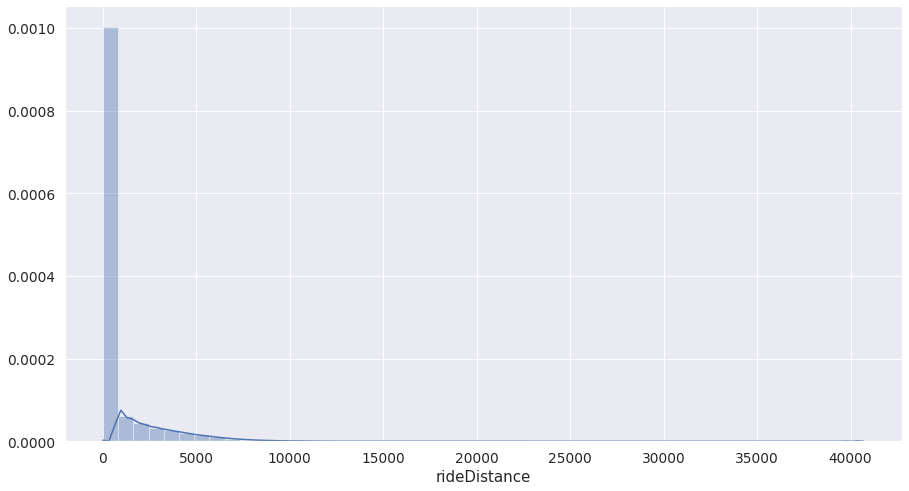

In [51]:
#while riding
show_distplot('rideDistance')


In [52]:
train[(train['rideDistance'] >= 30000) & (train['kills'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.000000,0,0,2,43,1120,0,0,0.0,2007,solo,83,83,-1,0,31960.0,0,0.0,0,0,402.100006,3,1449,0.8171,32362.099609,0.0,False
605623,8dee54600c67ca,e77f3e175b5959,26bc606cdae6bf,0,0,11.210000,0,0,0,27,1179,0,0,0.0,1851,solo,51,50,-1,0,33970.0,0,0.0,0,0,1641.000000,0,1498,0.6800,35611.000000,0.0,False
1232362,4bf27787223351,b0140dd17f3238,5ed9c405f7e71d,0,1,0.000000,0,0,10,47,0,0,0,0.0,1896,solo,95,91,1501,0,31010.0,0,0.0,1,0,1473.000000,3,0,0.7979,32483.000000,0.0,False
1725337,9f14f77b6dd9b6,8a2a8ae2506323,904b5fa7f59bc5,0,2,2.389000,0,0,5,19,1193,0,0,0.0,1918,solo,37,35,-1,0,37670.0,0,0.0,0,0,542.099976,2,1565,0.6944,38212.101562,0.0,False
2137063,73b793b4e7523f,f4444641af7e5c,6385f7641268c3,0,0,0.000000,0,0,0,52,0,0,0,0.0,1794,solo,94,92,1512,0,31370.0,0,0.0,0,0,28.760000,0,0,0.7204,31398.759766,0.0,False
2700691,3428324a089608,fa77b4ac736dbf,9b1c87f4016f47,0,1,31.270000,0,0,0,46,1211,0,0,0.0,1886,solo,98,95,-1,0,31290.0,0,0.0,0,0,174.100006,1,1530,0.8557,31464.099609,0.0,False
2927408,260efc0cf6b36c,b112f8d21e8185,3e977510ce1d3c,0,0,11.220000,0,0,0,44,1281,0,0,0.0,1865,solo,92,90,-1,0,30660.0,0,0.0,0,0,426.600006,2,1619,0.8132,31086.599609,0.0,False
3404578,8e84f4228e5436,c5ca5892142cbd,56775920f704e8,0,0,3.298000,0,0,0,40,1060,0,0,0.0,1877,solo,98,96,-1,0,32320.0,0,0.0,0,0,233.699997,5,1497,0.9175,32553.699219,0.0,False
3567265,99f342c6022411,9158efebffecc7,ddbe41fe165c7f,2,2,113.199997,0,0,3,34,0,0,0,0.0,1958,duo,48,47,1729,1,31020.0,0,0.0,0,0,616.200012,4,0,1.0000,31636.199219,0.0,False
4099938,afe34618b04d77,c14f532b283844,732c3b752e055f,0,0,0.000000,0,0,0,42,0,0,0,0.0,1939,solo,93,90,1486,0,40710.0,0,0.0,0,0,560.099976,0,0,0.8478,41270.101562,0.0,False


In [53]:
train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
219621,49e86bcbb74918,5bf4ac7f5f89a0,05a97d10e3cf81,0,0,100.000000,1,0,0,38,0,1,1,2.150000,1979,squad,26,26,1465,0,673.099976,1,0.0,0,0,0.0,0,0,0.0000,673.099976,0.0,False
1051447,c43116d1c3d4e5,bd09c97b67800a,aad60eee7eeb79,0,0,102.199997,0,0,0,34,1320,1,1,4.489000,1935,solo,89,85,-1,0,1757.000000,1,0.0,0,0,0.0,0,1532,0.1250,1757.000000,0.0,False
1053213,4a8011f19b0e0e,037c89b0cef255,238171821a1d0e,1,0,100.000000,1,0,0,38,1621,1,1,1.440000,1881,duo,48,45,-1,0,36.240002,0,0.0,0,0,0.0,0,1747,0.0638,36.240002,0.0,False
1166930,553f199b5538c5,560c2ba9dcbbd0,afb05e37d884fc,2,0,168.500000,1,0,0,45,1398,1,1,3.268000,1799,squad,31,29,-1,0,391.799988,1,0.0,0,0,0.0,0,1499,0.0667,391.799988,0.0,False
1479750,bcdf0f6c5d08bf,ea2ed2cc5955dd,2b59ed013eaf15,0,0,100.000000,1,0,0,46,0,1,1,3.744000,1882,duo,50,47,1509,0,468.299988,1,0.0,0,0,0.0,0,0,0.0612,468.299988,0.0,False
2221273,a280df87d394fc,61042f8c96538c,a0e8fe0599288c,0,0,100.000000,1,0,0,37,0,1,1,4.656000,1982,duo,47,44,1506,0,534.500000,1,0.0,0,0,0.0,0,0,0.1522,534.500000,0.0,False
2382410,adbda59d2f11cd,343d453ffb18c8,cbb5f864c6f532,0,0,100.000000,1,0,0,43,0,1,1,1.564000,1807,squad,26,22,1530,0,262.700012,1,0.0,0,0,0.0,0,0,0.0000,262.700012,0.0,False
2471705,b968373063f5a8,536e9c19659ce8,61c90034dc8174,0,0,93.470001,1,0,0,38,0,1,1,3.395000,1758,squad,29,26,1500,0,1360.000000,1,0.0,0,0,0.0,0,0,0.1429,1360.000000,0.0,False
2907639,2bf1d34142358b,71c15011651348,08dfa30b9390f7,4,0,578.000000,0,0,6,30,0,3,1,17.719999,1007,squad,6,6,1500,0,1277.000000,0,0.0,0,0,0.0,29,0,0.4000,1277.000000,0.0,False
3778837,ca3ca72549b07f,68a0c84f3b09aa,f72f06cafb3349,0,0,144.300003,2,0,0,20,1183,2,1,5.206000,1785,squad,28,26,-1,0,415.399994,0,0.0,0,0,0.0,0,1496,0.0000,415.399994,0.0,False


In [54]:
train[(train['_totalDistance'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.0,0,0,0,87,0,0,0,0.0,1530,duo,46,44,1534,0,0.0,0,0.0,0,0,0.0,0,0,0.0000,0.0,0.0,False
116,6adb021f5165ff,58e5500bd40898,de5c692fe25a73,0,0,0.0,0,0,0,68,311,0,0,0.0,1414,duo,41,36,0,0,0.0,0,0.0,0,0,0.0,0,847,0.0000,0.0,0.0,False
151,a2bbe20aa8789d,926e8a09bab249,e36e4203ed4831,0,0,0.0,0,0,0,92,309,0,0,0.0,1377,duo,48,41,-1,0,0.0,0,0.0,0,0,0.0,0,765,0.0000,0.0,0.0,False
237,baaa694658e085,d034728f22cff7,fa71620624d3e7,0,0,0.0,0,0,0,94,1397,0,0,0.0,1358,squad,29,26,-1,0,0.0,0,0.0,0,0,0.0,0,1510,0.0000,0.0,0.0,False
283,3ab8128e6bcbe6,bb52a209f2e938,aabd2650b129e2,0,0,0.0,0,0,0,84,0,0,0,0.0,1797,duo,48,47,1500,0,0.0,0,0.0,0,0,0.0,0,0,0.1277,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446843,56f1ff8594a328,63008ee9676bc3,b3f07953e112dc,0,0,0.0,0,0,0,99,0,0,0,0.0,1902,squad,30,30,1456,0,0.0,0,0.0,0,0,0.0,0,0,0.0000,0.0,0.0,False
4446849,19d2b52c9e17a3,f8a952ce9ab7aa,2afb2889026133,0,0,0.0,0,0,0,90,1243,0,0,0.0,1472,solo,98,93,-1,0,0.0,0,0.0,0,0,0.0,0,1363,0.0412,0.0,0.0,False
4446905,f93dfebceecc59,c54ca5bb9df107,e1da3a1ee799ef,0,0,0.0,0,0,0,89,0,0,0,0.0,1371,duo,49,48,1465,0,0.0,0,0.0,0,0,0.0,1,0,0.0417,0.0,0.0,False
4446926,e0c791ea3c4644,e18240dcce54f9,827639896a20cb,0,0,0.0,0,0,0,87,526,0,0,0.0,1811,squad,29,29,-1,0,0.0,0,0.0,0,0,0.0,0,916,0.0000,0.0,0.0,False


In [0]:
# Drop riding anomalies
train.drop(train[(train['rideDistance'] >= 30000) & (train['kills'] == 0)].index, inplace = True)
train.drop(train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)].index, inplace = True)
train.drop(train[(train['_totalDistance'] == 0)].index, inplace=True)

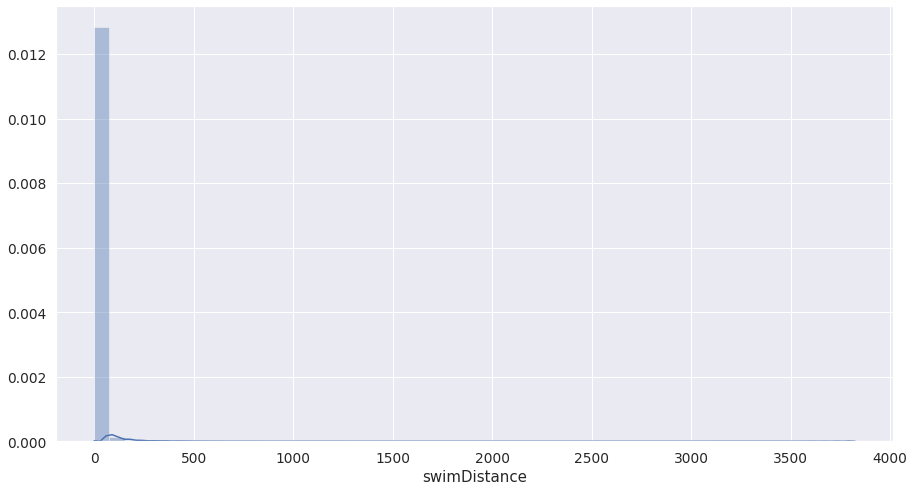

In [56]:
#swim distance
show_distplot('swimDistance')

In [60]:
train[train['swimDistance'] >= 2000]


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving


In [0]:
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

##**Anomalies like weapon acquiring etc**

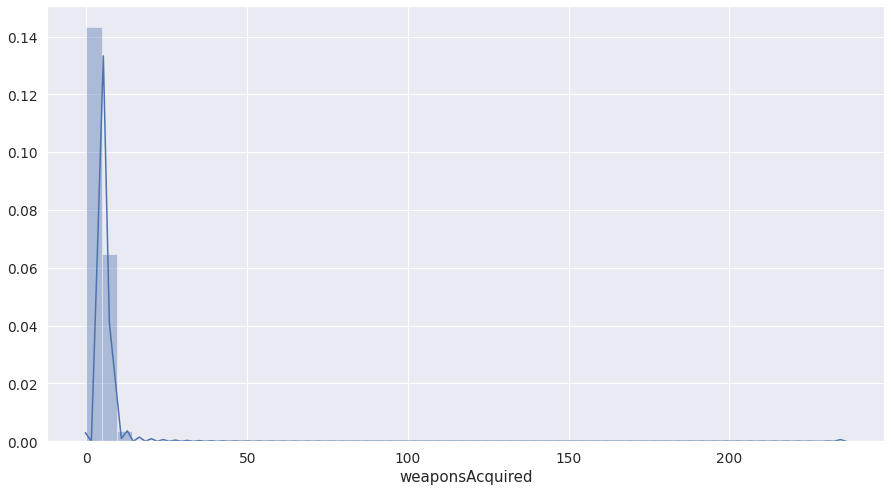

In [63]:
show_distplot('weaponsAcquired')

In [64]:
display(train[train['weaponsAcquired'] >= 70].shape)
train[train['weaponsAcquired'] >= 70].head()

(42, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
104825,4fe1c1b84d0e4c,62bc19a85c2ed8,17dea22cefe62a,3,0,2651.000000,0,3,3,9,0,24,3,31.000000,1798,duo,15,12,1500,0,3621.0,0,0.0,0,0,1024.0,71,0,0.9286,4645.0,0.125000,False
180523,aa4031a9ba3fbf,04f57c0cfb1306,5921b55b9e96b5,7,0,2869.000000,0,2,5,5,0,30,2,78.660004,1799,solo,16,14,1500,0,1671.0,0,0.0,0,0,1436.0,72,0,0.7333,3107.0,0.066667,False
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.110001,0,0,0,44,1279,0,0,0.000000,1901,duo,46,45,-1,0,1880.0,0,0.0,0,0,1307.0,128,1577,0.7111,3187.0,0.000000,False
422018,79497b3ad02a5e,64ec3f1e594f01,fa085380974299,0,4,184.500000,1,0,1,28,0,1,1,16.980000,1466,duo,49,46,1632,0,2546.0,0,0.0,0,0,1720.0,70,0,0.9792,4266.0,0.000000,False
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.300003,1,0,2,48,0,0,0,0.000000,1372,squad,29,29,1473,0,0.0,0,0.0,0,0,1687.0,80,0,0.7500,1687.0,0.000000,False


In [0]:
train.drop(train[train['weaponsAcquired'] >= 70].index, inplace=True)

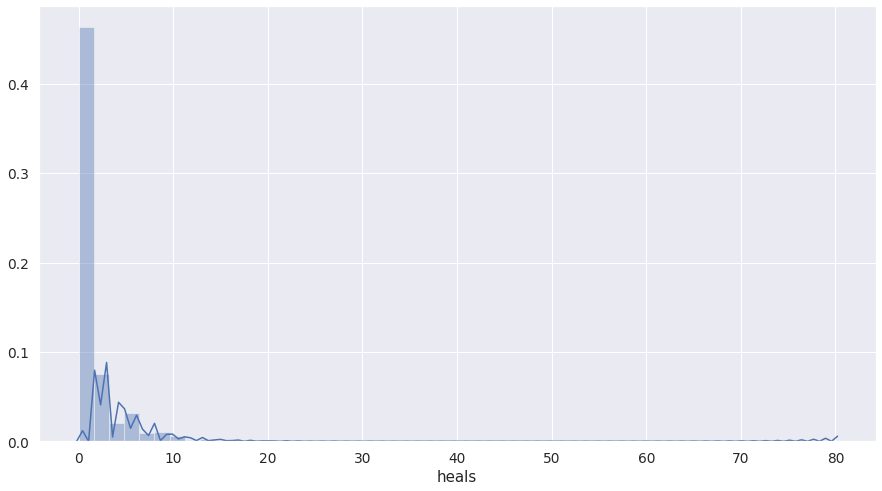

In [66]:
#in heals
show_distplot('heals')

In [67]:
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(10)

(135, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,0,0,0,0.000000,1797,solo,96,92,1527,0,5467.000000,0,0.000000,0,0,1387.000000,6,0,0.9368,6854.000000,0.000000,False
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,0,1,1,5.515000,1532,squad,27,27,1500,0,0.000000,0,292.399994,0,0,2791.000000,7,0,0.9615,3083.399902,1.000000,False
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,1331,0,0,0.000000,1374,solo,97,96,-1,0,0.000000,0,3.443000,0,0,1340.000000,3,1543,0.8333,1343.442993,0.000000,False
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,0,0,0,0.000000,1769,solo,97,94,1563,0,5934.000000,0,0.000000,0,0,1510.000000,6,0,0.8646,7444.000000,0.000000,False
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,0,0,0,0.000000,1878,solo,93,93,1500,0,3848.000000,0,0.000000,0,0,1968.000000,9,0,0.8370,5816.000000,0.000000,False
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.0,0,0,42,44,1359,0,0,0.000000,1295,squad,28,28,-1,0,0.000000,0,0.000000,0,0,2439.000000,2,1511,0.9259,2439.000000,0.000000,False
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.0,0,0,40,52,0,0,0,0.000000,1965,squad,30,29,1506,0,2596.000000,0,0.000000,0,0,2252.000000,8,0,0.8276,4848.000000,0.000000,False
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.0,2,1,47,25,1254,1,1,33.310001,1358,squad,32,31,-1,0,487.600006,0,0.000000,0,0,2928.000000,3,1562,0.9355,3415.600098,1.000000,False
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.0,0,8,41,9,1000,27,3,87.190002,1797,solo,37,22,-1,0,0.000000,0,0.000000,0,0,268.799988,33,1500,0.8889,268.799988,0.296296,False
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.5,3,1,44,3,1034,4,2,35.419998,1807,squad,28,25,-1,1,2438.000000,0,0.000000,0,0,2489.000000,6,1517,0.9630,4927.000000,0.250000,False


In [0]:
train.drop(train[train['heals'] >= 40].index, inplace=True)

##**Removing all anomalies from dataset**





In [69]:
train.shape

(4349347, 32)

In [0]:
train.to_csv('/content/drive/My Drive/PUBG Pred Data/cleaned_data.csv', index=False)

In [71]:
cleaned_data = pd.read_csv('/content/drive/My Drive/PUBG Pred Data/cleaned_data.csv')
cleaned_data = reduce_mem_usage(cleaned_data)

Memory usage of dataframe is 1032.82 MB --> 377.46 MB (Decreased by 63.5%)


# Part 3: Feature Engineering



##Experiment: Adding/Removing some new Features and finding thier correlation with the winPlace%

In [73]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0


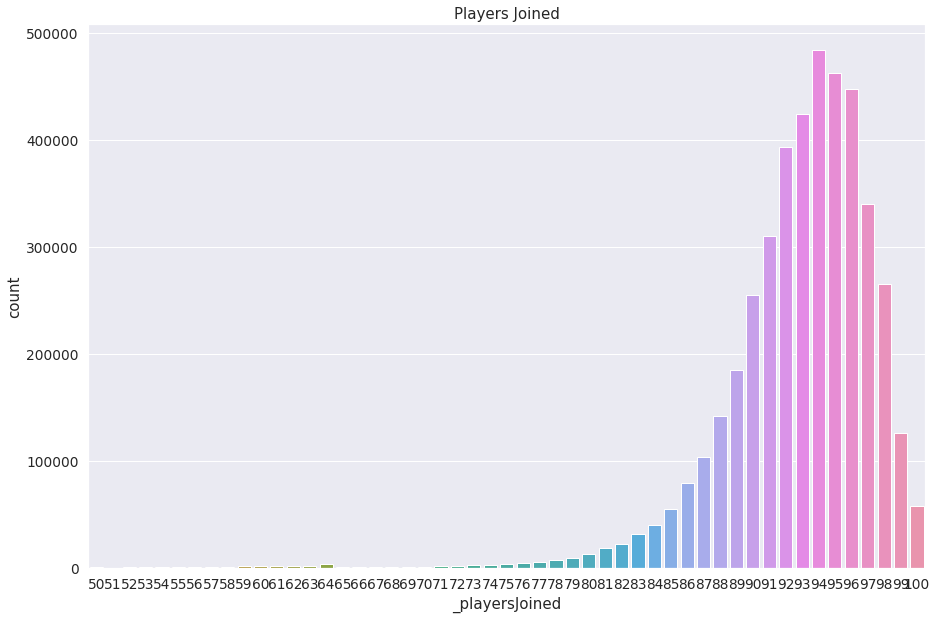

In [74]:
cleaned_data['_playersJoined'] = cleaned_data.groupby('matchId')['matchId'].transform('count')
data = cleaned_data.copy()
data = data[data['_playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['_playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

##**Normalization features**

In [75]:
# Create normalized features
cleaned_data['_killsNorm'] = cleaned_data['kills']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_damageDealtNorm'] = cleaned_data['damageDealt']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_maxPlaceNorm'] = cleaned_data['maxPlace']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_matchDurationNorm'] = cleaned_data['matchDuration']*((100-cleaned_data['_playersJoined'])/100 + 1)
# Compare standard features and normalized features
to_show = ['Id', 'kills','_killsNorm','damageDealt', '_damageDealtNorm', 'maxPlace', '_maxPlaceNorm', 'matchDuration', '_matchDurationNorm']
cleaned_data[to_show][0:11]

,Id,kills,_killsNorm,damageDealt,_damageDealtNorm,maxPlace,_maxPlaceNorm,matchDuration,_matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000000,0.000000,28,29.68,1306,1384.36
1,eef90569b9d03c,0,0.00,91.470001,100.617001,26,28.60,1777,1954.70
2,1eaf90ac73de72,0,0.00,68.000000,72.760000,50,53.50,1318,1410.26
3,4616d365dd2853,0,0.00,32.900002,35.861002,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.06,100.000000,106.000000,97,102.82,1424,1509.44
5,ff79c12f326506,1,1.09,100.000000,109.000000,28,30.52,1395,1520.55
6,95959be0e21ca3,0,0.00,0.000000,0.000000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538000,9.221040,96,103.68,1967,2124.36
8,1a68204ccf9891,0,0.00,51.599998,54.179998,28,29.40,1375,1443.75
9,e5bb5a43587253,0,0.00,37.270000,40.251600,29,31.32,1930,2084.40


In [76]:
match = cleaned_data.groupby('matchId')
cleaned_data['_killsPerc'] = match['kills'].rank(pct=True).values
cleaned_data['_killPlacePerc'] = match['killPlace'].rank(pct=True).values
cleaned_data['_walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
cleaned_data['_damageDealtPerc'] = match['damageDealt'].rank(pct=True).values
cleaned_data['_walkPerc_killsPerc'] = cleaned_data['_walkDistancePerc'] / cleaned_data['_killsPerc']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194


In [0]:
corr = cleaned_data[['_killsPerc', '_killPlacePerc','_walkDistancePerc','_damageDealtPerc', '_walkPerc_killsPerc','winPlacePerc']].corr()

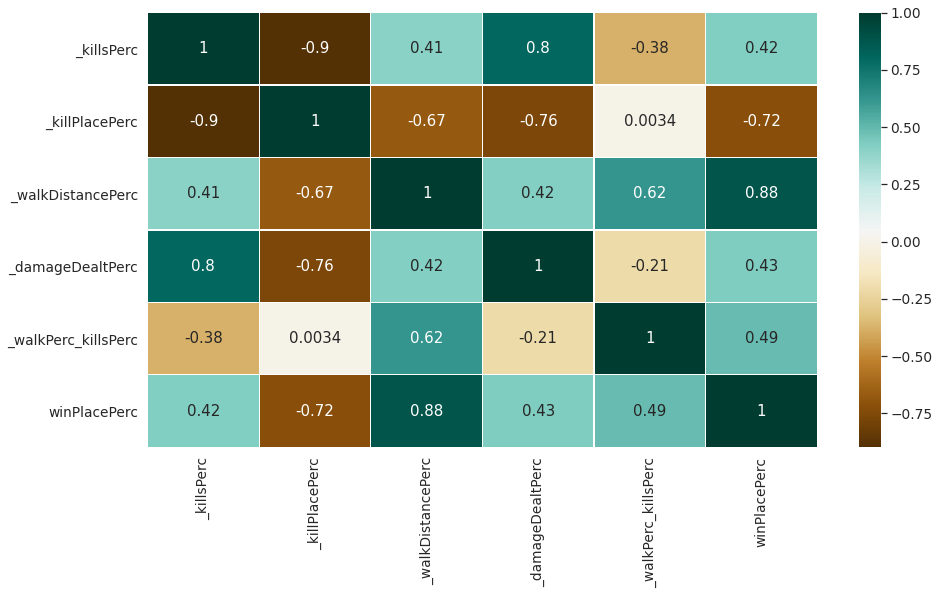

In [78]:
plt.figure(figsize=(15,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="BrBG"
)
plt.show()

In [79]:
agg = cleaned_data.groupby(['groupId']).size().to_frame('players_in_team')
cleaned_data = cleaned_data.merge(agg, how='left', on=['groupId'])
cleaned_data['_healthItems'] = cleaned_data['heals'] + cleaned_data['boosts']
cleaned_data['_headshotKillRate'] = cleaned_data['headshotKills'] / cleaned_data['kills']
cleaned_data['_killPlaceOverMaxPlace'] = cleaned_data['killPlace'] / cleaned_data['maxPlace']
cleaned_data['_killsOverWalkDistance'] = cleaned_data['kills'] / cleaned_data['walkDistance']
cleaned_data['_killsOverDistance'] = cleaned_data['kills'] / cleaned_data['_totalDistance']
cleaned_data['_walkDistancePerSec'] = cleaned_data['walkDistance'] / cleaned_data['matchDuration']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,_killsOverDistance,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,NaN,2.142857,0.000000,0.000000,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222,4,0,NaN,2.192308,0.000000,0.000000,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,NaN,0.940000,0.000000,0.000000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,NaN,2.419355,0.000000,0.000000,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.0,0.463918,0.020101,0.020101,0.034937


In [0]:
corr = cleaned_data[['killPlace', 'walkDistance','players_in_team','_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance', '_killsOverDistance','_walkDistancePerSec','winPlacePerc']].corr()

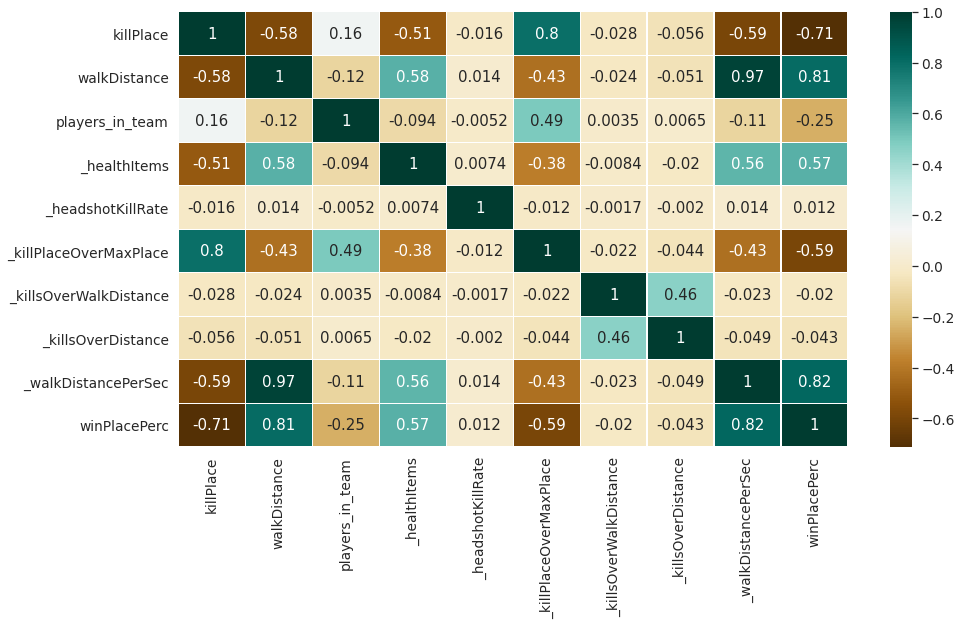

In [82]:
plt.figure(figsize=(15,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="BrBG"
)
plt.show()

In [84]:
cleaned_data.shape


(4349347, 49)

In [85]:
cleaned_data.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', '_totalDistance',
       '_headshot_rate', '_killsWithoutMoving', '_playersJoined', '_killsNorm',
       '_damageDealtNorm', '_maxPlaceNorm', '_matchDurationNorm', '_killsPerc',
       '_killPlacePerc', '_walkDistancePerc', '_damageDealtPerc',
       '_walkPerc_killsPerc', 'players_in_team', '_healthItems',
       '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance',
       '_killsOverDistance', '_walkDistancePerSec'],
      dtype='object')

In [0]:
cleaned_data.drop(['_headshotKillRate','_killsOverDistance', '_killsOverWalkDistance', ], axis=1, inplace=True)

In [87]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_killPlaceOverMaxPlace,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,2.142857,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222,4,0,2.192308,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,0.940000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,2.419355,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.463918,0.034937


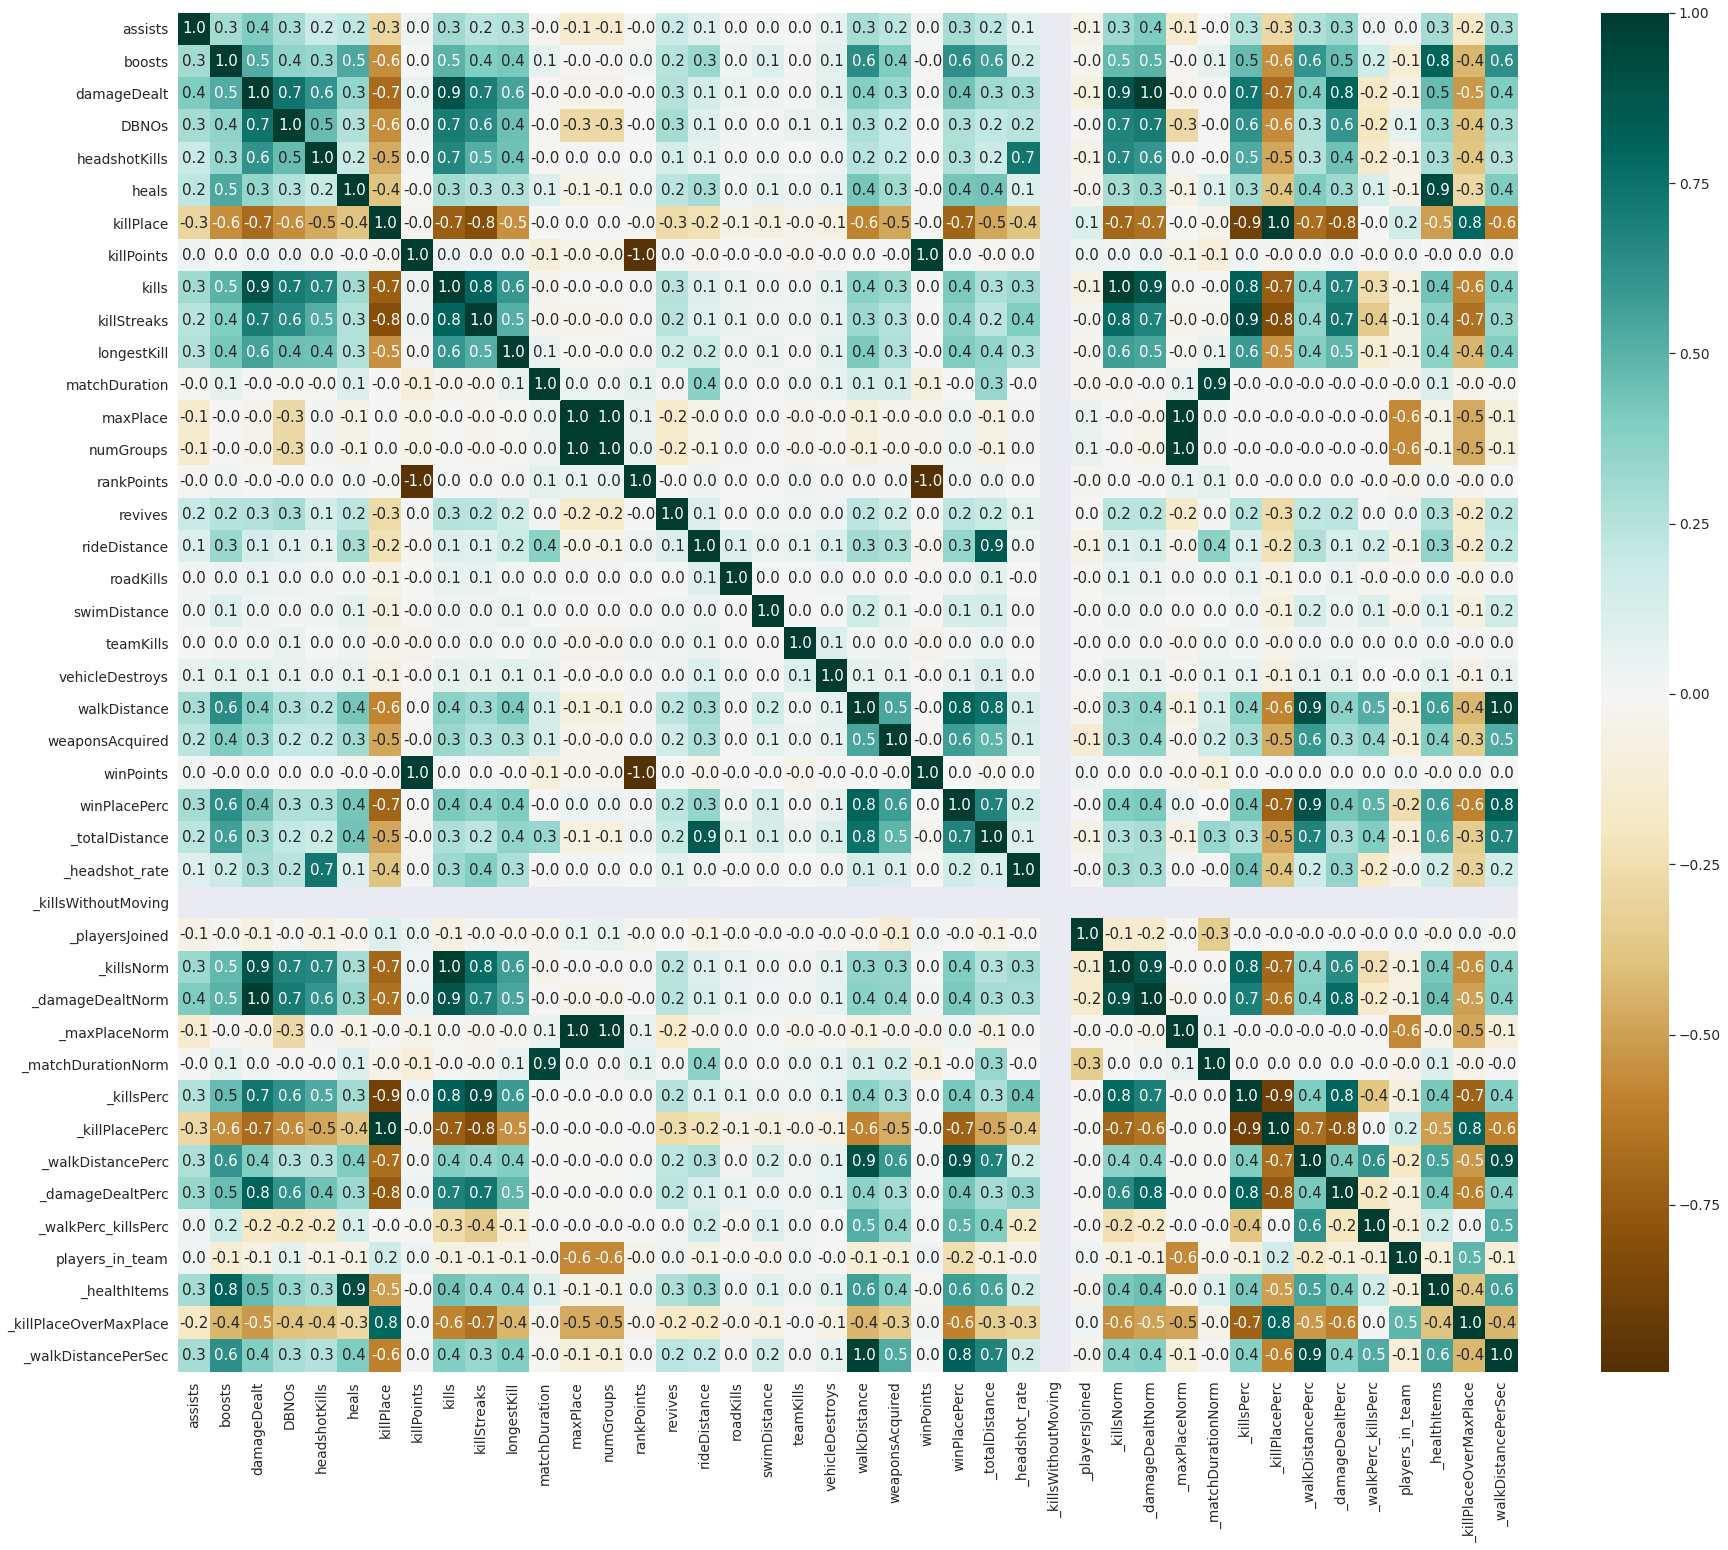

In [88]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(30, 25))
sns.heatmap(cleaned_data[cols_to_fit].corr(), annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()


##**Removing features having 0 correlation with winPlacePerc**


In [0]:
cleaned_data.drop(['killPoints','matchDuration','maxPlace','numGroups','rankPoints','roadKills','teamKills','winPoints', '_playersJoined', '_maxPlaceNorm', '_matchDurationNorm', '_killsWithoutMoving'], axis=1, inplace=True)
# cleaned_data.drop(['headshotKills','roadKills','vehicleDestroys'], axis=1, inplace=True)
# cleaned_data.drop(['rideDistance','swimDistance'], axis=1, inplace=True)
# cleaned_data.drop(['rankPoints','killPoints','winPoints'], axis=1, inplace=True)
# cleaned_data.drop(['maxPlace','numGroups','headshotKills','roadKills', 'teamKills','vehicleDestroys'], axis=1, inplace=True)
# cleaned_data.drop(['_headshot_rate'], axis=1, inplace=True)

In [94]:
cleaned_data.shape

(4349347, 34)

In [0]:
test.drop(['_playersJoined'], axis=1, inplace=True)

In [96]:
test.shape

(1934174, 28)

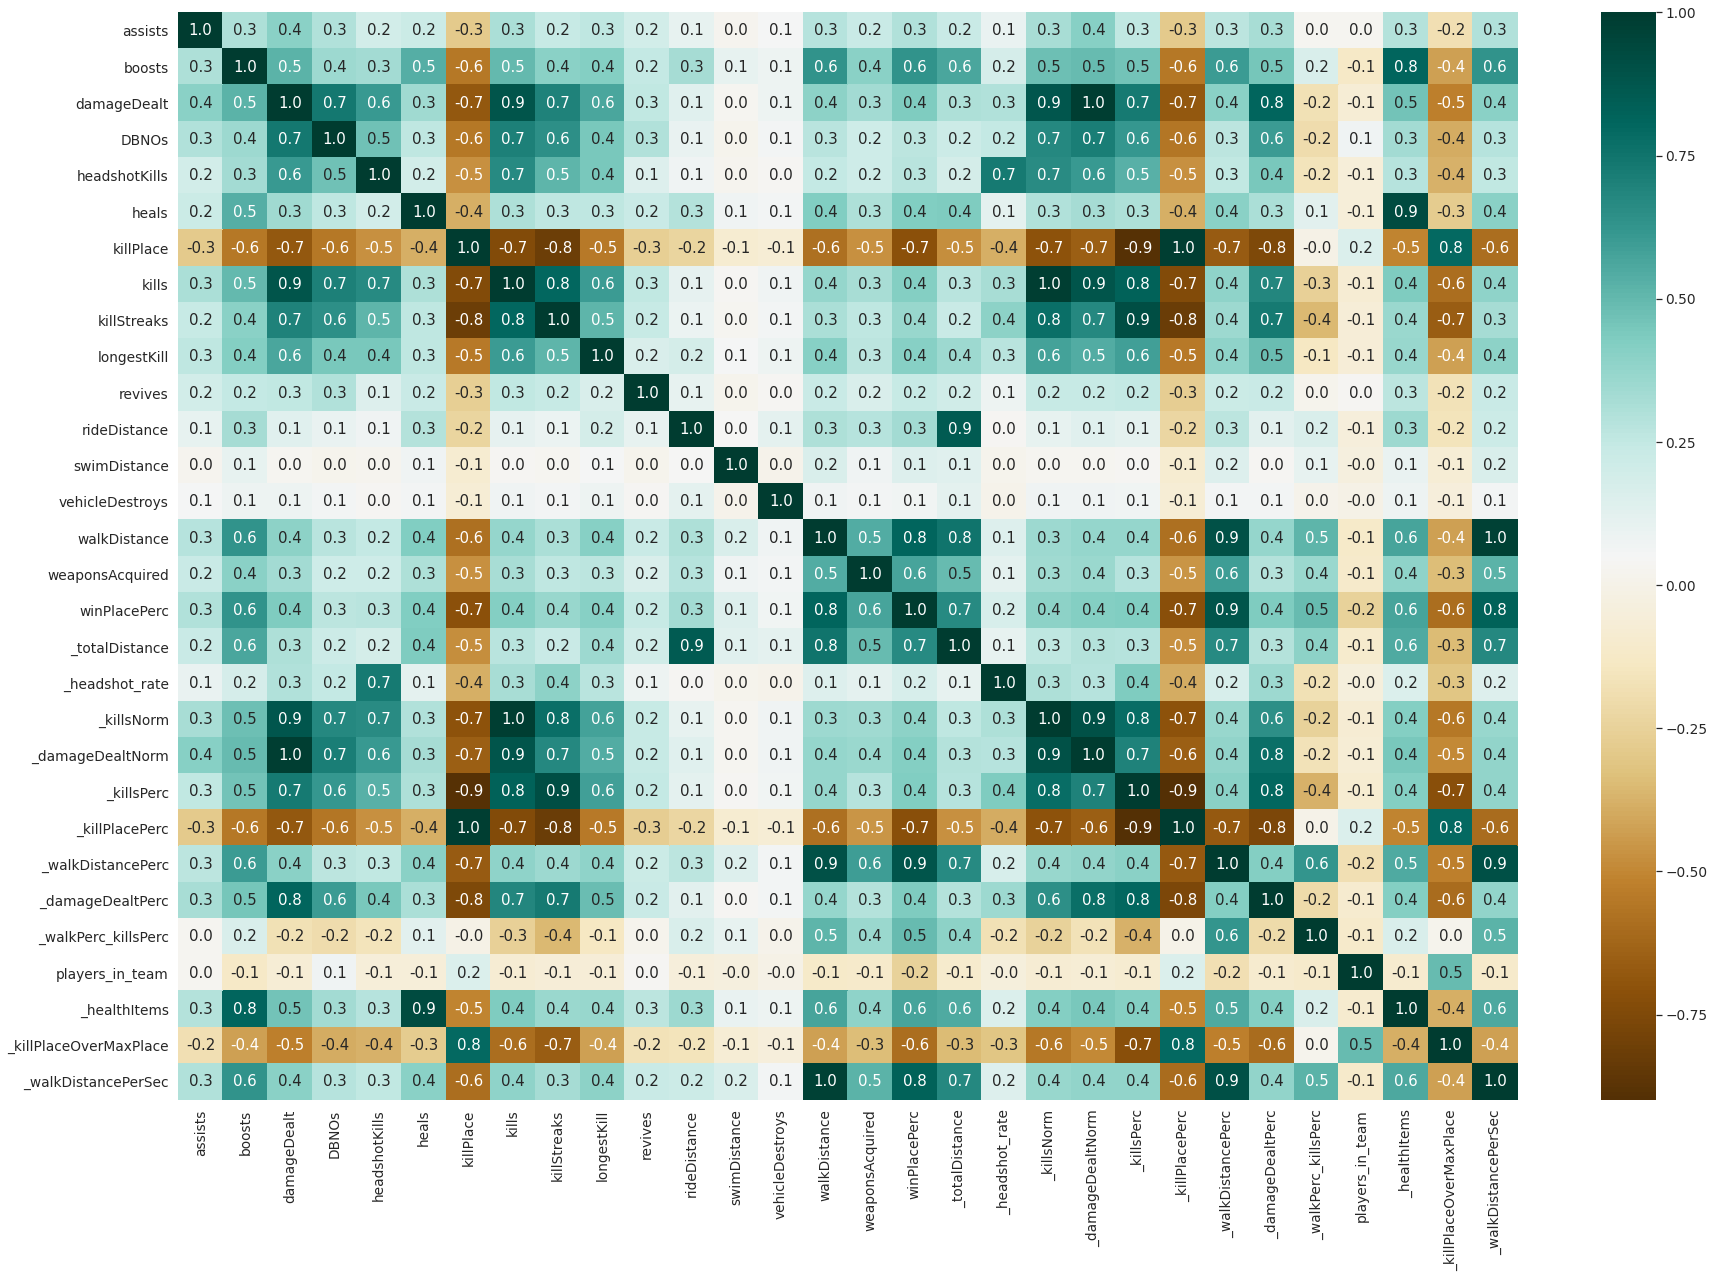

In [97]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr, annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

In [0]:
cleaned_data.to_csv(  '/content/drive/My Drive/PUBG Pred Data/Highly_correlated_data.csv', index=False)

#**FINAL PREDICTION**

Target variable: percentile

In [99]:
highly_corr = pd.read_csv('/content/drive/My Drive/PUBG Pred Data/Highly_correlated_data.csv')
highly_corr = reduce_mem_usage(highly_corr)

Memory usage of dataframe is 1128.22 MB --> 468.71 MB (Decreased by 58.5%)


In [100]:
highly_corr.shape

(4349347, 34)

In [101]:
X_train = highly_corr[highly_corr['winPlacePerc'].notnull()].reset_index(drop=True)
X_test = highly_corr[highly_corr['winPlacePerc'].isnull()].drop(['winPlacePerc'], axis=1).reset_index(drop=True)


Y_train = X_train.pop('winPlacePerc')
X_test_grp = X_test[['matchId','groupId']].copy()
train_matchId = X_train['matchId']

# drop matchId,groupId
X_train.drop(['matchId','groupId','Id'], axis=1, inplace=True)
X_test.drop(['matchId','groupId','Id'], axis=1, inplace=True)

print(X_train.shape, X_test.shape)

(4349347, 30) (0, 30)


In [102]:
print('There are {} different Match types in the dataset.'.format(highly_corr['matchType'].nunique()))

There are 3 different Match types in the dataset.


In [103]:
# One hot encode matchType
highly_corr = pd.get_dummies(highly_corr, columns=['matchType'])

# Take a look at the encoding
matchType_encoding = highly_corr.filter(regex='matchType')
matchType_encoding.head()

,matchType_duo,matchType_solo,matchType_squad
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0


In [104]:
# Turn groupId and match Id into categorical types
highly_corr['groupId'] = highly_corr['groupId'].astype('category')
highly_corr['matchId'] = highly_corr['matchId'].astype('category')

# Get category coding for groupId and matchID
highly_corr['groupId_cat'] = highly_corr['groupId'].cat.codes
highly_corr['matchId_cat'] = highly_corr['matchId'].cat.codes

# Get rid of old columns
highly_corr.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
highly_corr[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,609236,29996
1,821696,32654
2,837262,3131
3,1330560,45133
4,1744855,20468


In [0]:
highly_corr.drop(columns = ['Id'], inplace=True)

##ML 

In [0]:
sample = 500000
df_sample = highly_corr.sample(sample)

In [0]:
df = df_sample.drop(columns = ['winPlacePerc']) #all columns except target
y = df_sample['winPlacePerc'] # Only target variable

In [108]:
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# Check dimensions of samples
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 34) Sample target shape:  (440000,) Sample validation shape:  (60000, 34)


###MEAN ABS ERROR

In [0]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Function to print the MAE (Mean Absolute Error) score

def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    #Score of the training dataset obtained using an out-of-bag estimate.
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

###RANDOM FOREST MODEL

In [110]:
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.03095729701400774, 'mae val: ', 0.051457021959597025]


In [0]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [113]:
fi = rf_feat_importance(m1, df); fi[:15]

,cols,imp
22,_walkDistancePerc,0.164214
21,_killPlacePerc,0.142947
14,walkDistance,0.130212
28,_walkDistancePerSec,0.100100
6,killPlace,0.086579
16,_totalDistance,0.084848
1,boosts,0.056917
5,heals,0.043055
24,_walkPerc_killsPerc,0.038512
26,_healthItems,0.028267


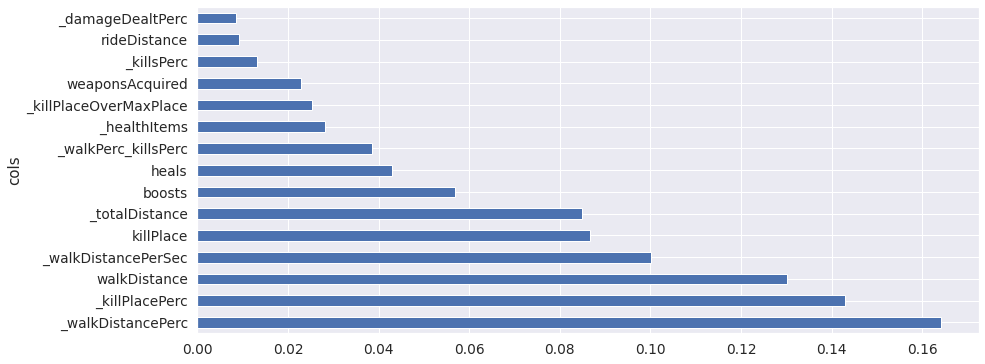

In [114]:
plot1 = fi[:15].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1

In [115]:
X_train.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', '_totalDistance', '_headshot_rate', '_killsNorm',
       '_damageDealtNorm', '_killsPerc', '_killPlacePerc', '_walkDistancePerc',
       '_damageDealtPerc', '_walkPerc_killsPerc', 'players_in_team',
       '_healthItems', '_killPlaceOverMaxPlace', '_walkDistancePerSec',
       'matchType_duo', 'matchType_solo', 'matchType_squad', 'groupId_cat',
       'matchId_cat'],
      dtype='object')

In [116]:
print(X_train.shape, y_train.shape)

(440000, 34) (440000,)


In [117]:
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

Significant features:  18


22         _walkDistancePerc
21            _killPlacePerc
14              walkDistance
28       _walkDistancePerSec
6                  killPlace
16            _totalDistance
1                     boosts
5                      heals
24       _walkPerc_killsPerc
26              _healthItems
27    _killPlaceOverMaxPlace
15           weaponsAcquired
20                _killsPerc
11              rideDistance
23          _damageDealtPerc
25           players_in_team
9                longestKill
18                _killsNorm
Name: cols, dtype: object

In [0]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [122]:
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

['mae train: ', 0.029283598068432618, 'mae val: ', 0.04983812898441278]


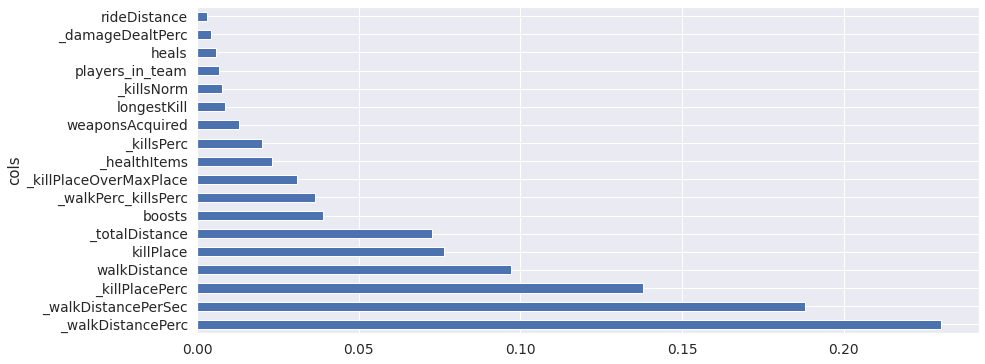

In [123]:
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

###View highly *correlated* features

[]

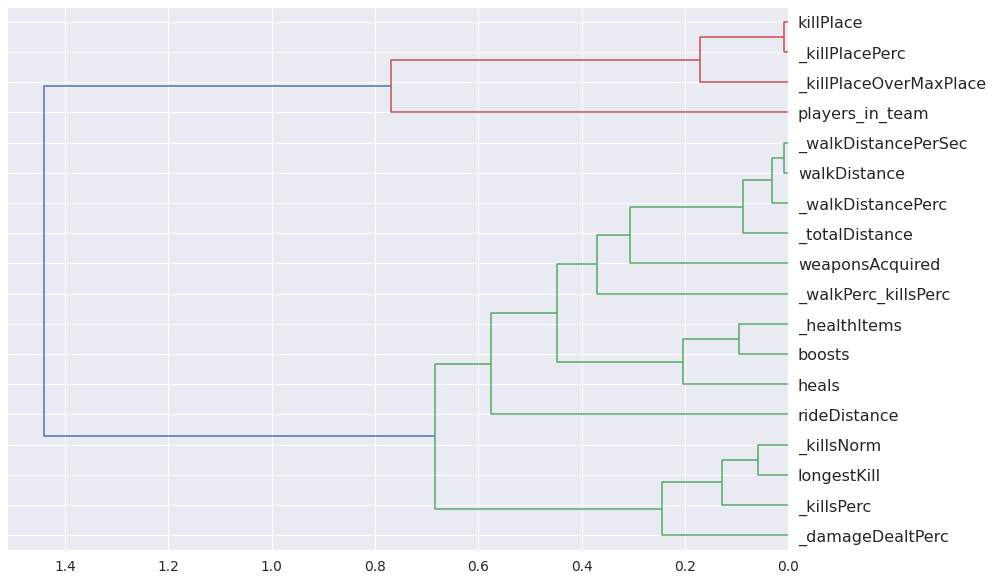

In [124]:
import scipy
from scipy.cluster import hierarchy as hc
# Create a Dendrogram to view highly correlated features
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.plot()

In [0]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [126]:
!pip install pdpbox
!pip install pandas_summary
!pip install plotnine

     |████████████████████████████████| 57.7MB 1.3MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=95fd8a0cb862bb54115cefdbaa27a5c9545ce622dfaa7046de637dd9bd25b3b2
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [127]:
df_keep.head()

,_walkDistancePerc,_killPlacePerc,walkDistance,_walkDistancePerSec,killPlace,_totalDistance,boosts,heals,_walkPerc_killsPerc,_healthItems,_killPlaceOverMaxPlace,weaponsAcquired,_killsPerc,rideDistance,_damageDealtPerc,players_in_team,longestKill,_killsNorm
2690593,0.873563,0.482759,2336.000000,1.681785,42,2354.370117,4,3,3.102041,7,0.893617,3,0.281609,0.0,0.413793,2,0.0,0.0
1636244,0.434783,0.652174,662.700012,0.481964,60,2316.599854,3,5,1.600000,8,1.276596,4,0.271739,1626.0,0.456522,2,0.0,0.0
3084663,0.250000,0.863636,348.399994,0.186510,76,348.399994,0,0,0.814815,0,2.620690,3,0.306818,0.0,0.465909,3,0.0,0.0
3724566,0.413043,0.652174,486.100006,0.360876,60,486.100006,0,1,1.381818,1,2.000000,7,0.298913,0.0,0.619565,3,0.0,0.0
2816555,0.041237,0.958763,8.029000,0.004387,93,8.029000,0,0,0.142857,0,1.860000,0,0.288660,0.0,0.340206,2,0.0,0.0


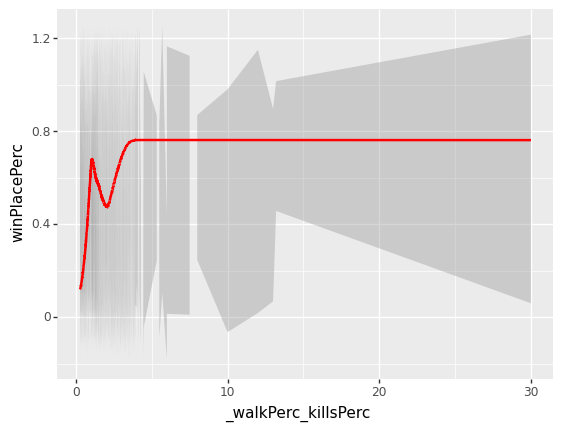

<ggplot: (-9223363273178169589)>

In [128]:
# from pdpbox import pdp
from plotnine import *
from pandas_summary import DataFrameSummary
x_all = get_sample(highly_corr, 100000)
ggplot(x_all, aes('_walkPerc_killsPerc','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

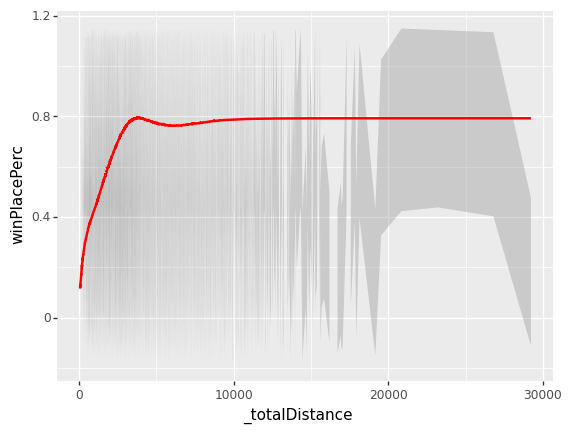

<ggplot: (-9223363273120823976)>

In [129]:
x_all = get_sample(highly_corr, 100000)
ggplot(x_all, aes('_totalDistance','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

In [130]:
# Prepare data
train = highly_corr.copy()
val_perc_full = 0.20 # % to use for validation set
n_valid_full = int(val_perc_full * len(train)) 
n_trn_full = len(train)-n_valid_full
df_full = train.drop(columns = ['winPlacePerc']) # all columns except target
y = train['winPlacePerc'] # target variable
df_full = df_full[to_keep] # Keep only relevant features
X_train, X_valid = split_vals(df_full, n_trn_full)
y_train, y_valid = split_vals(y, n_trn_full)

# Check dimensions of data
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (3479478, 18) Sample target shape:  (3479478,) Sample validation shape:  (869869, 18)


In [0]:
# Train final model
# You should get better results by increasing n_estimators
# and by playing around with the parameters
m3 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)

['mae train: ', 0.02546660676072762, 'mae val: ', 0.04704221408083837]


In [0]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.459999,0,0,0,73,0,0,0,0.000000,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.000000,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.100006,0,0,2,11,0,2,1,361.899994,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.000000,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.400000,0,0,4,49,0,0,0,0.000000,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.799988,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.519997,0,0,0,54,0,0,0,0.000000,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.000000,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.200012,1,2,1,7,0,3,1,60.060001,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.000000,4,0


In [0]:
train.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,_totalDistance,_headshot_rate,_killsNorm,_damageDealtNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_killPlaceOverMaxPlace,_walkDistancePerSec,matchType_duo,matchType_solo,matchType_squad,groupId_cat,matchId_cat
0,0,0,0.000000,0,0,0,60,0,0,0.000000,0,0.0000,0.00,0,244.800003,1,0.4444,244.800003,0.0,0.00,0.000000,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,2.142857,0.187443,0,0,1,609242,29996
1,0,0,91.470001,0,0,0,57,0,0,0.000000,0,0.0045,11.04,0,1434.000000,5,0.6400,1445.044556,0.0,0.00,100.617004,0.250000,0.633333,0.555556,0.433333,2.222222,4,0,2.192308,0.806978,0,0,1,821700,32654
2,1,0,68.000000,0,0,0,47,0,0,0.000000,0,0.0000,0.00,0,161.800003,2,0.7755,161.800003,0.0,0.00,72.760002,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,0.940000,0.122762,1,0,0,837266,3131
3,0,0,32.900002,0,0,0,75,0,0,0.000000,0,0.0000,0.00,0,202.699997,3,0.1667,202.699997,0.0,0.00,35.861000,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,2.419355,0.141156,0,0,1,1330566,45133
4,0,0,100.000000,0,0,0,45,1,1,58.529999,0,0.0000,0.00,0,49.750000,2,0.1875,49.750000,0.0,1.06,106.000000,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.463918,0.034937,0,1,0,1744863,20468


###Modifying the test data

In [0]:
test = pd.read_csv('/content/drive/My Drive/PUBG Pred Data/test_V2.csv')
test = reduce_mem_usage(test)

Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)


In [0]:
#Adding same features to test data
agg = test.groupby(['groupId']).size().to_frame('players_in_team')
test = test.merge(agg, how='left', on=['groupId'])
test['_headshot_rate'] = test['headshotKills'] / test['kills']
test['_headshot_rate'] = test['_headshot_rate'].fillna(0)
test['_totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['_playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['_killsNorm'] = test['kills']*((100-test['_playersJoined'])/100 + 1)
test['_damageDealtNorm'] = test['damageDealt']*((100-test['_playersJoined'])/100 + 1)
test['_healthItems'] = test['heals'] + test['boosts']
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['_totalDistance'] == 0))
test['_killPlacePerc'] = test['killPlace'].rank(pct=True).values
test['_killsPerc'] = test['kills'].rank(pct=True).values
test['_walkDistancePerc'] = test['walkDistance'].rank(pct=True).values
test['_walkPerc_killsPerc'] = test['_walkDistancePerc'] / test['_killsPerc']
test['_killPlaceOverMaxPlace'] = test['killPlace'] / test['maxPlace']
test['_killsPerc'] = test['kills'].rank(pct=True).values
test['_walkDistancePerc'] = test['walkDistance'].rank(pct=True).values
test['_walkDistancePerSec'] = test['walkDistance'] / test['matchDuration']

In [0]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,groupId_cat,matchId_cat,_headshot_rate,_totalDistance,_playersJoined,_killsNorm,_damageDealtNorm,_healthItems,killsWithoutMoving,_killPlacePerc,_killsPerc,_walkDistancePerc,_walkPerc_killsPerc,_killPlaceOverMaxPlace,players_in_team,_walkDistancePerSec
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.459999,0,0,0,73,0,0,0,0.000000,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.000000,1,0,357523,5514,0.000000,588.000000,92,0.00,55.576799,0,False,0.766654,0.284210,0.475680,1.673695,2.607143,4,0.312102
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.100006,0,0,2,11,0,2,1,361.899994,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.000000,6,0,231759,5268,0.000000,6686.000000,96,2.08,186.264006,6,False,0.111587,0.831127,0.758297,0.912373,0.229167,2,1.113749
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.400000,0,0,4,49,0,0,0,0.000000,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.799988,4,0,39107,10783,0.000000,787.799988,94,0.00,24.804000,4,False,0.513972,0.284210,0.525046,1.847389,1.750000,4,0.439375
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.519997,0,0,0,54,0,0,0,0.000000,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.000000,3,0,634157,2174,0.000000,1812.000000,89,0.00,72.727196,0,False,0.566769,0.284210,0.722077,2.540649,1.200000,2,0.988004
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.200012,1,2,1,7,0,3,1,60.060001,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.000000,4,0,352749,5106,0.666667,2963.000000,95,3.15,346.710013,5,False,0.069081,0.910626,0.906597,0.995576,0.250000,3,2.234540


In [0]:
# Turn groupId and match Id into categorical types
test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')

# Get category coding for groupId and matchID
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes

In [0]:
test_pred = test[to_keep].copy()

# Fill NaN with 0 (temporary)
test_pred.fillna(0, inplace=True)
test_pred.head()

,_walkDistancePerc,_totalDistance,_killPlacePerc,walkDistance,_walkDistancePerSec,killPlace,_killPlaceOverMaxPlace,_healthItems,boosts,weaponsAcquired,_walkPerc_killsPerc,_killsPerc,heals,_damageDealtNorm,rideDistance,damageDealt,longestKill,players_in_team,_killsNorm
0,0.475680,588.000000,0.766654,588.000000,0.312102,73,2.607143,0,0,1,1.673695,0.284210,0,55.576799,0.0,51.459999,0.000000,4,0.00
1,0.758297,6686.000000,0.111587,2017.000000,1.113749,11,0.229167,6,4,6,0.912373,0.831127,2,186.264006,4669.0,179.100006,361.899994,2,2.08
2,0.525046,787.799988,0.513972,787.799988,0.439375,49,1.750000,4,0,4,1.847389,0.284210,4,24.804000,0.0,23.400000,0.000000,4,0.00
3,0.722077,1812.000000,0.566769,1812.000000,0.988004,54,1.200000,0,0,3,2.540649,0.284210,0,72.727196,0.0,65.519997,0.000000,2,0.00
4,0.906597,2963.000000,0.069081,2963.000000,2.234540,7,0.250000,5,4,4,0.995576,0.910626,1,346.710013,0.0,330.200012,60.060001,3,3.15


## Predicting the final winPlacePerc

In [0]:
predictions = np.clip(a = m3.predict(test_pred), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test['Id'], 'winPlacePerc' : predictions})
pred_df

,Id,winPlacePerc
0,9329eb41e215eb,0.271098
1,639bd0dcd7bda8,0.937192
2,63d5c8ef8dfe91,0.765491
3,cf5b81422591d1,0.632383
4,ee6a295187ba21,0.959230
...,...,...
1934169,a316c3a13887d5,0.797911
1934170,5312146b27d875,0.462261
1934171,fc8818b5b32ad3,0.911775
1934172,a0f91e35f8458f,0.831347


In [0]:
#Create submission file
pred_df.to_csv("submission.csv", index=False)